In [1]:
# Step 1: Install FFTW
!apt-get install libfftw3-dev
!apt-get install libfftw3-mpi-dev
#!pip install cython==3.0.1
# Step 2: Set paths for Dedalus installation
import os
import matplotlib.pyplot as plt
os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"


# Step 3: Install Dedalus using pip
!echo "Cython<3" > cython_constraint.txt
!CC=mpicc PIP_CONSTRAINT=cython_constraint.txt pip3 install --no-cache http://github.com/dedalusproject/dedalus/zipball/master/
#!CC=mpicc PIP_CONSTRAINT=cython_constraint.txt pip install dedalus

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import dedalus.public as de
from dedalus.extras import flow_tools
from dedalus.tools import post
import shutil
import random
import time
import h5py
import pathlib
import logging

logger = logging.getLogger('2D RB Convection')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 18 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-single3 amd64 3.3.8-2ubuntu8 [800 kB]
Get:5 http://archive.

2023-10-10 12:39:22,039 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.


2023-10-10 12:39:22,046 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
INFO:numexpr.utils:NumExpr defaulting to 2 threads.


2023-10-10 12:39:22,323 numexpr.utils 0/1 INFO :: NumExpr defaulting to 2 threads.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# clean up the destination files
#!rm -rf /content/gdrive/MyDrive/website-hugo/chaos_and_predictability/week3/RB2D/simulation/snapshots
!rm -fr /content/snapshots/*

In [4]:
import dedalus.public as d3
import logging
# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
x, z = np.linspace(0, Lx, Nx), np.linspace(0, Lz, Nz)
mx, mz = np.meshgrid(x, z)
Rayleigh = 1e5#1e2#1e1#10#2e6
Prandtl = 1
dealias = 3/2
stop_sim_time = 200#50
timestepper = d3.RK222
max_timestep = 0.1#0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
b = dist.Field(name='b', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_b1 = dist.Field(name='tau_b1', bases=xbasis)
tau_b2 = dist.Field(name='tau_b2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)

# Substitutions
kappa = (Rayleigh * Prandtl)**(-1/2)
nu = (Rayleigh / Prandtl)**(-1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_b = d3.grad(b) + ez*lift(tau_b1) # First-order reduction

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, b, u, tau_p, tau_b1, tau_b2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(b) - kappa*div(grad_b) + lift(tau_b2) = - u@grad(b)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) - b*ez + lift(tau_u2) = - u@grad(u)")
problem.add_equation("b(z=0) = Lz")
problem.add_equation("u(z=0) = 0")
problem.add_equation("b(z=Lz) = 0")
problem.add_equation("u(z=Lz) = 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
b.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
b['g'] *= z * (Lz - z) # Damp noise at walls
b['g'] += Lz - z # Add linear background
#b['g'] -= z.max()/2 * ((np.sqrt((((mx - x.max()/2)** 2)/64 + (mz - z.max()/2)**2)))>0.1).transpose()

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(b, name='buoyancy')
snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
            # add after
            if np.isnan(max_Re): break
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()



DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: Trace(Grad(u) + ez*<Field 134493842350352>*tau_u1) + C(C(tau_p))
DEBUG:problems:  RHS: 0
DEBUG:problems:  condition: True
DEBUG:problems:  M: 0
DEBUG:problems:  L: Trace(Grad(u) + ez*<Field 134493842350352>*tau_u1) + C(C(tau_p))
DEBUG:problems:  F: <Field 134493964348160>
DEBUG:problems:Adding equation 1
DEBUG:problems:  LHS: C(dt(b)) + -1*0.0031622776601683794*Div(Grad(b) + ez*<Field 134493842350352>*tau_b1) + C(<Field 134493842350352>*tau_b2)
DEBUG:problems:  RHS: -1*u@Grad(b)
DEBUG:problems:  condition: True
DEBUG:problems:  M: C(b)
DEBUG:problems:  L: -1*0.0031622776601683794*Div(Grad(b) + ez*<Field 134493842350352>*tau_b1) + C(<Field 134493842350352>*tau_b2)
DEBUG:problems:  F: C(-1*u@Grad(b))
DEBUG:problems:Adding equation 2
DEBUG:problems:  LHS: C(dt(u)) + -1*0.0031622776601683794*Div(Grad(u) + ez*<Field 134493842350352>*tau_u1) + C(Grad(p)) + C(-1*b*ez) + C(<Field 134493842350352>*tau_u2)
DEBUG:pr

2023-10-10 14:16:06,339 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 31s, Rate: 4.1e+00/s


INFO:subsystems:Building subproblem matrices 13/128 (~10%) Elapsed: 2s, Remaining: 20s, Rate: 5.7e+00/s


2023-10-10 14:16:08,363 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 2s, Remaining: 20s, Rate: 5.7e+00/s


INFO:subsystems:Building subproblem matrices 26/128 (~20%) Elapsed: 4s, Remaining: 16s, Rate: 6.6e+00/s


2023-10-10 14:16:10,056 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 4s, Remaining: 16s, Rate: 6.6e+00/s


INFO:subsystems:Building subproblem matrices 39/128 (~30%) Elapsed: 5s, Remaining: 12s, Rate: 7.4e+00/s


2023-10-10 14:16:11,369 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 5s, Remaining: 12s, Rate: 7.4e+00/s


INFO:subsystems:Building subproblem matrices 52/128 (~41%) Elapsed: 6s, Remaining: 9s, Rate: 8.1e+00/s


2023-10-10 14:16:12,482 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 6s, Remaining: 9s, Rate: 8.1e+00/s


INFO:subsystems:Building subproblem matrices 65/128 (~51%) Elapsed: 7s, Remaining: 7s, Rate: 8.9e+00/s


2023-10-10 14:16:13,421 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 7s, Remaining: 7s, Rate: 8.9e+00/s


INFO:subsystems:Building subproblem matrices 78/128 (~61%) Elapsed: 8s, Remaining: 5s, Rate: 9.4e+00/s


2023-10-10 14:16:14,365 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 8s, Remaining: 5s, Rate: 9.4e+00/s


INFO:subsystems:Building subproblem matrices 91/128 (~71%) Elapsed: 9s, Remaining: 4s, Rate: 9.9e+00/s


2023-10-10 14:16:15,265 subsystems 0/1 INFO :: Building subproblem matrices 91/128 (~71%) Elapsed: 9s, Remaining: 4s, Rate: 9.9e+00/s


INFO:subsystems:Building subproblem matrices 103/128 (~80%) Elapsed: 10s, Remaining: 2s, Rate: 1.0e+01/s


2023-10-10 14:16:16,124 subsystems 0/1 INFO :: Building subproblem matrices 103/128 (~80%) Elapsed: 10s, Remaining: 2s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 104/128 (~81%) Elapsed: 10s, Remaining: 2s, Rate: 1.0e+01/s


2023-10-10 14:16:16,210 subsystems 0/1 INFO :: Building subproblem matrices 104/128 (~81%) Elapsed: 10s, Remaining: 2s, Rate: 1.0e+01/s


INFO:subsystems:Building subproblem matrices 117/128 (~91%) Elapsed: 11s, Remaining: 1s, Rate: 1.1e+01/s


2023-10-10 14:16:17,162 subsystems 0/1 INFO :: Building subproblem matrices 117/128 (~91%) Elapsed: 11s, Remaining: 1s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 128/128 (~100%) Elapsed: 12s, Remaining: 0s, Rate: 1.1e+01/s


2023-10-10 14:16:17,929 subsystems 0/1 INFO :: Building subproblem matrices 128/128 (~100%) Elapsed: 12s, Remaining: 0s, Rate: 1.1e+01/s


DEBUG:solvers:Finished IVP instantiation
INFO:2D RB Convection:Starting main loop


2023-10-10 14:16:17,967 2D RB Convection 0/1 INFO :: Starting main loop


DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (256, 64), 0)
DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 64), 1)
DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256, 96), 1)
DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (2, 256, 96), 2)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 96), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (2, 384, 96), 1)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (384, 1), 0)
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (2, 384, 1), 1)
DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (2, 256, 96), 2)
DEBUG:transforms:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (2, 

2023-10-10 14:16:18,997 2D RB Convection 0/1 INFO :: Iteration=1, Time=1.000000e-01, dt=1.000000e-01, max(Re)=0.000000


INFO:2D RB Convection:Iteration=11, Time=1.100000e+00, dt=1.000000e-01, max(Re)=0.009510


2023-10-10 14:16:20,265 2D RB Convection 0/1 INFO :: Iteration=11, Time=1.100000e+00, dt=1.000000e-01, max(Re)=0.009510


INFO:2D RB Convection:Iteration=21, Time=2.100000e+00, dt=1.000000e-01, max(Re)=0.016268


2023-10-10 14:16:21,890 2D RB Convection 0/1 INFO :: Iteration=21, Time=2.100000e+00, dt=1.000000e-01, max(Re)=0.016268


INFO:2D RB Convection:Iteration=31, Time=3.100000e+00, dt=1.000000e-01, max(Re)=0.028943


2023-10-10 14:16:24,233 2D RB Convection 0/1 INFO :: Iteration=31, Time=3.100000e+00, dt=1.000000e-01, max(Re)=0.028943


INFO:2D RB Convection:Iteration=41, Time=4.100000e+00, dt=1.000000e-01, max(Re)=0.056520


2023-10-10 14:16:26,196 2D RB Convection 0/1 INFO :: Iteration=41, Time=4.100000e+00, dt=1.000000e-01, max(Re)=0.056520


INFO:2D RB Convection:Iteration=51, Time=5.100000e+00, dt=1.000000e-01, max(Re)=0.110434


2023-10-10 14:16:27,334 2D RB Convection 0/1 INFO :: Iteration=51, Time=5.100000e+00, dt=1.000000e-01, max(Re)=0.110434


INFO:2D RB Convection:Iteration=61, Time=6.100000e+00, dt=1.000000e-01, max(Re)=0.215345


2023-10-10 14:16:28,446 2D RB Convection 0/1 INFO :: Iteration=61, Time=6.100000e+00, dt=1.000000e-01, max(Re)=0.215345


INFO:2D RB Convection:Iteration=71, Time=7.100000e+00, dt=1.000000e-01, max(Re)=0.420086


2023-10-10 14:16:29,567 2D RB Convection 0/1 INFO :: Iteration=71, Time=7.100000e+00, dt=1.000000e-01, max(Re)=0.420086


INFO:2D RB Convection:Iteration=81, Time=8.100000e+00, dt=1.000000e-01, max(Re)=0.820599


2023-10-10 14:16:30,745 2D RB Convection 0/1 INFO :: Iteration=81, Time=8.100000e+00, dt=1.000000e-01, max(Re)=0.820599


INFO:2D RB Convection:Iteration=91, Time=9.100000e+00, dt=1.000000e-01, max(Re)=1.605204


2023-10-10 14:16:31,872 2D RB Convection 0/1 INFO :: Iteration=91, Time=9.100000e+00, dt=1.000000e-01, max(Re)=1.605204


INFO:2D RB Convection:Iteration=101, Time=1.010000e+01, dt=1.000000e-01, max(Re)=3.145445


2023-10-10 14:16:33,047 2D RB Convection 0/1 INFO :: Iteration=101, Time=1.010000e+01, dt=1.000000e-01, max(Re)=3.145445


INFO:2D RB Convection:Iteration=111, Time=1.110000e+01, dt=1.000000e-01, max(Re)=6.173003


2023-10-10 14:16:34,187 2D RB Convection 0/1 INFO :: Iteration=111, Time=1.110000e+01, dt=1.000000e-01, max(Re)=6.173003


INFO:2D RB Convection:Iteration=121, Time=1.210000e+01, dt=1.000000e-01, max(Re)=12.124188


2023-10-10 14:16:35,294 2D RB Convection 0/1 INFO :: Iteration=121, Time=1.210000e+01, dt=1.000000e-01, max(Re)=12.124188


INFO:2D RB Convection:Iteration=131, Time=1.310000e+01, dt=1.000000e-01, max(Re)=23.784224


2023-10-10 14:16:36,989 2D RB Convection 0/1 INFO :: Iteration=131, Time=1.310000e+01, dt=1.000000e-01, max(Re)=23.784224


INFO:2D RB Convection:Iteration=141, Time=1.410000e+01, dt=1.000000e-01, max(Re)=46.277394


2023-10-10 14:16:39,185 2D RB Convection 0/1 INFO :: Iteration=141, Time=1.410000e+01, dt=1.000000e-01, max(Re)=46.277394


INFO:2D RB Convection:Iteration=151, Time=1.491901e+01, dt=8.190108e-02, max(Re)=78.764694


2023-10-10 14:16:41,689 2D RB Convection 0/1 INFO :: Iteration=151, Time=1.491901e+01, dt=8.190108e-02, max(Re)=78.764694


INFO:2D RB Convection:Iteration=161, Time=1.539724e+01, dt=4.782317e-02, max(Re)=106.369217


2023-10-10 14:16:43,475 2D RB Convection 0/1 INFO :: Iteration=161, Time=1.539724e+01, dt=4.782317e-02, max(Re)=106.369217


INFO:2D RB Convection:Iteration=171, Time=1.574061e+01, dt=3.433644e-02, max(Re)=128.818829


2023-10-10 14:16:45,252 2D RB Convection 0/1 INFO :: Iteration=171, Time=1.574061e+01, dt=3.433644e-02, max(Re)=128.818829


INFO:2D RB Convection:Iteration=181, Time=1.601549e+01, dt=2.748797e-02, max(Re)=147.787800


2023-10-10 14:16:46,977 2D RB Convection 0/1 INFO :: Iteration=181, Time=1.601549e+01, dt=2.748797e-02, max(Re)=147.787800


INFO:2D RB Convection:Iteration=191, Time=1.624839e+01, dt=2.329014e-02, max(Re)=163.933342


2023-10-10 14:16:48,722 2D RB Convection 0/1 INFO :: Iteration=191, Time=1.624839e+01, dt=2.329014e-02, max(Re)=163.933342


INFO:2D RB Convection:Iteration=201, Time=1.645280e+01, dt=2.044109e-02, max(Re)=177.527914


2023-10-10 14:16:50,499 2D RB Convection 0/1 INFO :: Iteration=201, Time=1.645280e+01, dt=2.044109e-02, max(Re)=177.527914


INFO:2D RB Convection:Iteration=211, Time=1.663698e+01, dt=1.841861e-02, max(Re)=188.716913


2023-10-10 14:16:53,462 2D RB Convection 0/1 INFO :: Iteration=211, Time=1.663698e+01, dt=1.841861e-02, max(Re)=188.716913


INFO:2D RB Convection:Iteration=221, Time=1.680639e+01, dt=1.694007e-02, max(Re)=197.586710


2023-10-10 14:16:56,161 2D RB Convection 0/1 INFO :: Iteration=221, Time=1.680639e+01, dt=1.694007e-02, max(Re)=197.586710


INFO:2D RB Convection:Iteration=231, Time=1.696486e+01, dt=1.584749e-02, max(Re)=204.493120


2023-10-10 14:16:57,855 2D RB Convection 0/1 INFO :: Iteration=231, Time=1.696486e+01, dt=1.584749e-02, max(Re)=204.493120


INFO:2D RB Convection:Iteration=241, Time=1.711532e+01, dt=1.504624e-02, max(Re)=209.332935


2023-10-10 14:16:59,562 2D RB Convection 0/1 INFO :: Iteration=241, Time=1.711532e+01, dt=1.504624e-02, max(Re)=209.332935


INFO:2D RB Convection:Iteration=251, Time=1.726579e+01, dt=1.504624e-02, max(Re)=212.168020


2023-10-10 14:17:00,708 2D RB Convection 0/1 INFO :: Iteration=251, Time=1.726579e+01, dt=1.504624e-02, max(Re)=212.168020


INFO:2D RB Convection:Iteration=261, Time=1.740519e+01, dt=1.394082e-02, max(Re)=212.892920


2023-10-10 14:17:02,424 2D RB Convection 0/1 INFO :: Iteration=261, Time=1.740519e+01, dt=1.394082e-02, max(Re)=212.892920


INFO:2D RB Convection:Iteration=271, Time=1.754460e+01, dt=1.394082e-02, max(Re)=211.753601


2023-10-10 14:17:03,529 2D RB Convection 0/1 INFO :: Iteration=271, Time=1.754460e+01, dt=1.394082e-02, max(Re)=211.753601


INFO:2D RB Convection:Iteration=281, Time=1.768401e+01, dt=1.394082e-02, max(Re)=208.846956


2023-10-10 14:17:04,628 2D RB Convection 0/1 INFO :: Iteration=281, Time=1.768401e+01, dt=1.394082e-02, max(Re)=208.846956


INFO:2D RB Convection:Iteration=291, Time=1.782342e+01, dt=1.394082e-02, max(Re)=207.240166


2023-10-10 14:17:05,839 2D RB Convection 0/1 INFO :: Iteration=291, Time=1.782342e+01, dt=1.394082e-02, max(Re)=207.240166


INFO:2D RB Convection:Iteration=301, Time=1.796283e+01, dt=1.394082e-02, max(Re)=205.594201


2023-10-10 14:17:08,094 2D RB Convection 0/1 INFO :: Iteration=301, Time=1.796283e+01, dt=1.394082e-02, max(Re)=205.594201


INFO:2D RB Convection:Iteration=311, Time=1.810223e+01, dt=1.394082e-02, max(Re)=202.644765


2023-10-10 14:17:10,436 2D RB Convection 0/1 INFO :: Iteration=311, Time=1.810223e+01, dt=1.394082e-02, max(Re)=202.644765


INFO:2D RB Convection:Iteration=321, Time=1.824164e+01, dt=1.394082e-02, max(Re)=198.638706


2023-10-10 14:17:11,681 2D RB Convection 0/1 INFO :: Iteration=321, Time=1.824164e+01, dt=1.394082e-02, max(Re)=198.638706


INFO:2D RB Convection:Iteration=331, Time=1.838105e+01, dt=1.394082e-02, max(Re)=200.597352


2023-10-10 14:17:12,831 2D RB Convection 0/1 INFO :: Iteration=331, Time=1.838105e+01, dt=1.394082e-02, max(Re)=200.597352


INFO:2D RB Convection:Iteration=341, Time=1.852046e+01, dt=1.394082e-02, max(Re)=201.419738


2023-10-10 14:17:13,987 2D RB Convection 0/1 INFO :: Iteration=341, Time=1.852046e+01, dt=1.394082e-02, max(Re)=201.419738


INFO:2D RB Convection:Iteration=351, Time=1.865987e+01, dt=1.394082e-02, max(Re)=201.235980


2023-10-10 14:17:15,092 2D RB Convection 0/1 INFO :: Iteration=351, Time=1.865987e+01, dt=1.394082e-02, max(Re)=201.235980


INFO:2D RB Convection:Iteration=361, Time=1.879928e+01, dt=1.394082e-02, max(Re)=205.010734


2023-10-10 14:17:16,200 2D RB Convection 0/1 INFO :: Iteration=361, Time=1.879928e+01, dt=1.394082e-02, max(Re)=205.010734


INFO:2D RB Convection:Iteration=371, Time=1.893868e+01, dt=1.394082e-02, max(Re)=212.126368


2023-10-10 14:17:17,331 2D RB Convection 0/1 INFO :: Iteration=371, Time=1.893868e+01, dt=1.394082e-02, max(Re)=212.126368


INFO:2D RB Convection:Iteration=381, Time=1.908800e+01, dt=1.493135e-02, max(Re)=218.462690


2023-10-10 14:17:19,058 2D RB Convection 0/1 INFO :: Iteration=381, Time=1.908800e+01, dt=1.493135e-02, max(Re)=218.462690


INFO:2D RB Convection:Iteration=391, Time=1.923731e+01, dt=1.493135e-02, max(Re)=222.639238


2023-10-10 14:17:20,241 2D RB Convection 0/1 INFO :: Iteration=391, Time=1.923731e+01, dt=1.493135e-02, max(Re)=222.639238


INFO:2D RB Convection:Iteration=401, Time=1.938662e+01, dt=1.493135e-02, max(Re)=224.396219


2023-10-10 14:17:22,098 2D RB Convection 0/1 INFO :: Iteration=401, Time=1.938662e+01, dt=1.493135e-02, max(Re)=224.396219


INFO:2D RB Convection:Iteration=411, Time=1.953594e+01, dt=1.493135e-02, max(Re)=223.986043


2023-10-10 14:17:24,404 2D RB Convection 0/1 INFO :: Iteration=411, Time=1.953594e+01, dt=1.493135e-02, max(Re)=223.986043


INFO:2D RB Convection:Iteration=421, Time=1.968525e+01, dt=1.493135e-02, max(Re)=221.741140


2023-10-10 14:17:26,090 2D RB Convection 0/1 INFO :: Iteration=421, Time=1.968525e+01, dt=1.493135e-02, max(Re)=221.741140


INFO:2D RB Convection:Iteration=431, Time=1.983456e+01, dt=1.493135e-02, max(Re)=217.960448


2023-10-10 14:17:27,233 2D RB Convection 0/1 INFO :: Iteration=431, Time=1.983456e+01, dt=1.493135e-02, max(Re)=217.960448


INFO:2D RB Convection:Iteration=441, Time=1.998388e+01, dt=1.493135e-02, max(Re)=213.215009


2023-10-10 14:17:28,315 2D RB Convection 0/1 INFO :: Iteration=441, Time=1.998388e+01, dt=1.493135e-02, max(Re)=213.215009


INFO:2D RB Convection:Iteration=451, Time=2.013319e+01, dt=1.493135e-02, max(Re)=207.465565


2023-10-10 14:17:29,441 2D RB Convection 0/1 INFO :: Iteration=451, Time=2.013319e+01, dt=1.493135e-02, max(Re)=207.465565


INFO:2D RB Convection:Iteration=461, Time=2.028250e+01, dt=1.493135e-02, max(Re)=201.026734


2023-10-10 14:17:30,573 2D RB Convection 0/1 INFO :: Iteration=461, Time=2.028250e+01, dt=1.493135e-02, max(Re)=201.026734


INFO:2D RB Convection:Iteration=471, Time=2.044010e+01, dt=1.575995e-02, max(Re)=193.810690


2023-10-10 14:17:32,257 2D RB Convection 0/1 INFO :: Iteration=471, Time=2.044010e+01, dt=1.575995e-02, max(Re)=193.810690


INFO:2D RB Convection:Iteration=481, Time=2.059770e+01, dt=1.575995e-02, max(Re)=186.308170


2023-10-10 14:17:33,433 2D RB Convection 0/1 INFO :: Iteration=481, Time=2.059770e+01, dt=1.575995e-02, max(Re)=186.308170


INFO:2D RB Convection:Iteration=491, Time=2.075530e+01, dt=1.575995e-02, max(Re)=178.728696


2023-10-10 14:17:34,547 2D RB Convection 0/1 INFO :: Iteration=491, Time=2.075530e+01, dt=1.575995e-02, max(Re)=178.728696


INFO:2D RB Convection:Iteration=501, Time=2.091290e+01, dt=1.575995e-02, max(Re)=173.399314


2023-10-10 14:17:35,712 2D RB Convection 0/1 INFO :: Iteration=501, Time=2.091290e+01, dt=1.575995e-02, max(Re)=173.399314


INFO:2D RB Convection:Iteration=511, Time=2.107050e+01, dt=1.575995e-02, max(Re)=169.486467


2023-10-10 14:17:38,052 2D RB Convection 0/1 INFO :: Iteration=511, Time=2.107050e+01, dt=1.575995e-02, max(Re)=169.486467


INFO:2D RB Convection:Iteration=521, Time=2.122810e+01, dt=1.575995e-02, max(Re)=165.467380


2023-10-10 14:17:40,291 2D RB Convection 0/1 INFO :: Iteration=521, Time=2.122810e+01, dt=1.575995e-02, max(Re)=165.467380


INFO:2D RB Convection:Iteration=531, Time=2.138570e+01, dt=1.575995e-02, max(Re)=161.528960


2023-10-10 14:17:41,569 2D RB Convection 0/1 INFO :: Iteration=531, Time=2.138570e+01, dt=1.575995e-02, max(Re)=161.528960


INFO:2D RB Convection:Iteration=541, Time=2.154330e+01, dt=1.575995e-02, max(Re)=158.233470


2023-10-10 14:17:42,686 2D RB Convection 0/1 INFO :: Iteration=541, Time=2.154330e+01, dt=1.575995e-02, max(Re)=158.233470


INFO:2D RB Convection:Iteration=551, Time=2.170927e+01, dt=1.659654e-02, max(Re)=154.850907


2023-10-10 14:17:44,368 2D RB Convection 0/1 INFO :: Iteration=551, Time=2.170927e+01, dt=1.659654e-02, max(Re)=154.850907


INFO:2D RB Convection:Iteration=561, Time=2.187523e+01, dt=1.659654e-02, max(Re)=151.650988


2023-10-10 14:17:45,470 2D RB Convection 0/1 INFO :: Iteration=561, Time=2.187523e+01, dt=1.659654e-02, max(Re)=151.650988


INFO:2D RB Convection:Iteration=571, Time=2.204120e+01, dt=1.659654e-02, max(Re)=148.764708


2023-10-10 14:17:46,580 2D RB Convection 0/1 INFO :: Iteration=571, Time=2.204120e+01, dt=1.659654e-02, max(Re)=148.764708


INFO:2D RB Convection:Iteration=581, Time=2.221862e+01, dt=1.774241e-02, max(Re)=146.130737


2023-10-10 14:17:48,265 2D RB Convection 0/1 INFO :: Iteration=581, Time=2.221862e+01, dt=1.774241e-02, max(Re)=146.130737


INFO:2D RB Convection:Iteration=591, Time=2.239605e+01, dt=1.774241e-02, max(Re)=143.961002


2023-10-10 14:17:49,376 2D RB Convection 0/1 INFO :: Iteration=591, Time=2.239605e+01, dt=1.774241e-02, max(Re)=143.961002


INFO:2D RB Convection:Iteration=601, Time=2.257347e+01, dt=1.774241e-02, max(Re)=142.325943


2023-10-10 14:17:50,490 2D RB Convection 0/1 INFO :: Iteration=601, Time=2.257347e+01, dt=1.774241e-02, max(Re)=142.325943


INFO:2D RB Convection:Iteration=611, Time=2.275089e+01, dt=1.774241e-02, max(Re)=141.242325


2023-10-10 14:17:52,439 2D RB Convection 0/1 INFO :: Iteration=611, Time=2.275089e+01, dt=1.774241e-02, max(Re)=141.242325


INFO:2D RB Convection:Iteration=621, Time=2.292832e+01, dt=1.774241e-02, max(Re)=140.697935


2023-10-10 14:17:55,299 2D RB Convection 0/1 INFO :: Iteration=621, Time=2.292832e+01, dt=1.774241e-02, max(Re)=140.697935


INFO:2D RB Convection:Iteration=631, Time=2.310574e+01, dt=1.774241e-02, max(Re)=141.441302


2023-10-10 14:17:56,603 2D RB Convection 0/1 INFO :: Iteration=631, Time=2.310574e+01, dt=1.774241e-02, max(Re)=141.441302


INFO:2D RB Convection:Iteration=641, Time=2.328317e+01, dt=1.774241e-02, max(Re)=143.047003


2023-10-10 14:17:57,739 2D RB Convection 0/1 INFO :: Iteration=641, Time=2.328317e+01, dt=1.774241e-02, max(Re)=143.047003


INFO:2D RB Convection:Iteration=651, Time=2.346997e+01, dt=1.868011e-02, max(Re)=144.915722


2023-10-10 14:17:59,463 2D RB Convection 0/1 INFO :: Iteration=651, Time=2.346997e+01, dt=1.868011e-02, max(Re)=144.915722


INFO:2D RB Convection:Iteration=661, Time=2.365677e+01, dt=1.868011e-02, max(Re)=146.719280


2023-10-10 14:18:00,608 2D RB Convection 0/1 INFO :: Iteration=661, Time=2.365677e+01, dt=1.868011e-02, max(Re)=146.719280


INFO:2D RB Convection:Iteration=671, Time=2.384357e+01, dt=1.868011e-02, max(Re)=148.312401


2023-10-10 14:18:01,743 2D RB Convection 0/1 INFO :: Iteration=671, Time=2.384357e+01, dt=1.868011e-02, max(Re)=148.312401


INFO:2D RB Convection:Iteration=681, Time=2.403037e+01, dt=1.868011e-02, max(Re)=149.565747


2023-10-10 14:18:02,868 2D RB Convection 0/1 INFO :: Iteration=681, Time=2.403037e+01, dt=1.868011e-02, max(Re)=149.565747


INFO:2D RB Convection:Iteration=691, Time=2.421717e+01, dt=1.868011e-02, max(Re)=152.138936


2023-10-10 14:18:04,030 2D RB Convection 0/1 INFO :: Iteration=691, Time=2.421717e+01, dt=1.868011e-02, max(Re)=152.138936


INFO:2D RB Convection:Iteration=701, Time=2.440397e+01, dt=1.868011e-02, max(Re)=154.266268


2023-10-10 14:18:05,144 2D RB Convection 0/1 INFO :: Iteration=701, Time=2.440397e+01, dt=1.868011e-02, max(Re)=154.266268


INFO:2D RB Convection:Iteration=711, Time=2.459077e+01, dt=1.868011e-02, max(Re)=156.033119


2023-10-10 14:18:06,833 2D RB Convection 0/1 INFO :: Iteration=711, Time=2.459077e+01, dt=1.868011e-02, max(Re)=156.033119


INFO:2D RB Convection:Iteration=721, Time=2.477757e+01, dt=1.868011e-02, max(Re)=157.274594


2023-10-10 14:18:09,024 2D RB Convection 0/1 INFO :: Iteration=721, Time=2.477757e+01, dt=1.868011e-02, max(Re)=157.274594


INFO:2D RB Convection:Iteration=731, Time=2.496438e+01, dt=1.868011e-02, max(Re)=158.021417


2023-10-10 14:18:10,860 2D RB Convection 0/1 INFO :: Iteration=731, Time=2.496438e+01, dt=1.868011e-02, max(Re)=158.021417


INFO:2D RB Convection:Iteration=741, Time=2.515118e+01, dt=1.868011e-02, max(Re)=159.036048


2023-10-10 14:18:12,015 2D RB Convection 0/1 INFO :: Iteration=741, Time=2.515118e+01, dt=1.868011e-02, max(Re)=159.036048


INFO:2D RB Convection:Iteration=751, Time=2.533798e+01, dt=1.868011e-02, max(Re)=163.305216


2023-10-10 14:18:13,141 2D RB Convection 0/1 INFO :: Iteration=751, Time=2.533798e+01, dt=1.868011e-02, max(Re)=163.305216


INFO:2D RB Convection:Iteration=761, Time=2.552478e+01, dt=1.868011e-02, max(Re)=167.798367


2023-10-10 14:18:14,257 2D RB Convection 0/1 INFO :: Iteration=761, Time=2.552478e+01, dt=1.868011e-02, max(Re)=167.798367


INFO:2D RB Convection:Iteration=771, Time=2.571158e+01, dt=1.868011e-02, max(Re)=171.699762


2023-10-10 14:18:15,353 2D RB Convection 0/1 INFO :: Iteration=771, Time=2.571158e+01, dt=1.868011e-02, max(Re)=171.699762


INFO:2D RB Convection:Iteration=781, Time=2.589838e+01, dt=1.868011e-02, max(Re)=175.190764


2023-10-10 14:18:16,497 2D RB Convection 0/1 INFO :: Iteration=781, Time=2.589838e+01, dt=1.868011e-02, max(Re)=175.190764


INFO:2D RB Convection:Iteration=791, Time=2.608518e+01, dt=1.868011e-02, max(Re)=178.197934


2023-10-10 14:18:17,605 2D RB Convection 0/1 INFO :: Iteration=791, Time=2.608518e+01, dt=1.868011e-02, max(Re)=178.197934


INFO:2D RB Convection:Iteration=801, Time=2.627198e+01, dt=1.868011e-02, max(Re)=180.376464


2023-10-10 14:18:18,718 2D RB Convection 0/1 INFO :: Iteration=801, Time=2.627198e+01, dt=1.868011e-02, max(Re)=180.376464


INFO:2D RB Convection:Iteration=811, Time=2.645878e+01, dt=1.868011e-02, max(Re)=181.696706


2023-10-10 14:18:19,842 2D RB Convection 0/1 INFO :: Iteration=811, Time=2.645878e+01, dt=1.868011e-02, max(Re)=181.696706


INFO:2D RB Convection:Iteration=821, Time=2.664559e+01, dt=1.868011e-02, max(Re)=182.139783


2023-10-10 14:18:21,489 2D RB Convection 0/1 INFO :: Iteration=821, Time=2.664559e+01, dt=1.868011e-02, max(Re)=182.139783


INFO:2D RB Convection:Iteration=831, Time=2.683239e+01, dt=1.868011e-02, max(Re)=182.148716


2023-10-10 14:18:23,795 2D RB Convection 0/1 INFO :: Iteration=831, Time=2.683239e+01, dt=1.868011e-02, max(Re)=182.148716


INFO:2D RB Convection:Iteration=841, Time=2.700385e+01, dt=1.714595e-02, max(Re)=181.581591


2023-10-10 14:18:26,048 2D RB Convection 0/1 INFO :: Iteration=841, Time=2.700385e+01, dt=1.714595e-02, max(Re)=181.581591


INFO:2D RB Convection:Iteration=851, Time=2.717531e+01, dt=1.714595e-02, max(Re)=180.392117


2023-10-10 14:18:27,172 2D RB Convection 0/1 INFO :: Iteration=851, Time=2.717531e+01, dt=1.714595e-02, max(Re)=180.392117


INFO:2D RB Convection:Iteration=861, Time=2.733790e+01, dt=1.625988e-02, max(Re)=178.618429


2023-10-10 14:18:28,868 2D RB Convection 0/1 INFO :: Iteration=861, Time=2.733790e+01, dt=1.625988e-02, max(Re)=178.618429


INFO:2D RB Convection:Iteration=871, Time=2.750050e+01, dt=1.625988e-02, max(Re)=176.778724


2023-10-10 14:18:29,999 2D RB Convection 0/1 INFO :: Iteration=871, Time=2.750050e+01, dt=1.625988e-02, max(Re)=176.778724


INFO:2D RB Convection:Iteration=881, Time=2.766310e+01, dt=1.625988e-02, max(Re)=174.523797


2023-10-10 14:18:31,110 2D RB Convection 0/1 INFO :: Iteration=881, Time=2.766310e+01, dt=1.625988e-02, max(Re)=174.523797


INFO:2D RB Convection:Iteration=891, Time=2.782570e+01, dt=1.625988e-02, max(Re)=173.058597


2023-10-10 14:18:32,237 2D RB Convection 0/1 INFO :: Iteration=891, Time=2.782570e+01, dt=1.625988e-02, max(Re)=173.058597


INFO:2D RB Convection:Iteration=901, Time=2.797981e+01, dt=1.541075e-02, max(Re)=172.251196


2023-10-10 14:18:33,924 2D RB Convection 0/1 INFO :: Iteration=901, Time=2.797981e+01, dt=1.541075e-02, max(Re)=172.251196


INFO:2D RB Convection:Iteration=911, Time=2.813392e+01, dt=1.541075e-02, max(Re)=170.954924


2023-10-10 14:18:35,023 2D RB Convection 0/1 INFO :: Iteration=911, Time=2.813392e+01, dt=1.541075e-02, max(Re)=170.954924


INFO:2D RB Convection:Iteration=921, Time=2.828802e+01, dt=1.541075e-02, max(Re)=169.629865


2023-10-10 14:18:37,055 2D RB Convection 0/1 INFO :: Iteration=921, Time=2.828802e+01, dt=1.541075e-02, max(Re)=169.629865


INFO:2D RB Convection:Iteration=931, Time=2.844213e+01, dt=1.541075e-02, max(Re)=168.106843


2023-10-10 14:18:39,412 2D RB Convection 0/1 INFO :: Iteration=931, Time=2.844213e+01, dt=1.541075e-02, max(Re)=168.106843


INFO:2D RB Convection:Iteration=941, Time=2.859624e+01, dt=1.541075e-02, max(Re)=166.558762


2023-10-10 14:18:40,888 2D RB Convection 0/1 INFO :: Iteration=941, Time=2.859624e+01, dt=1.541075e-02, max(Re)=166.558762


INFO:2D RB Convection:Iteration=951, Time=2.875035e+01, dt=1.541075e-02, max(Re)=164.545217


2023-10-10 14:18:42,029 2D RB Convection 0/1 INFO :: Iteration=951, Time=2.875035e+01, dt=1.541075e-02, max(Re)=164.545217


INFO:2D RB Convection:Iteration=961, Time=2.890445e+01, dt=1.541075e-02, max(Re)=162.780795


2023-10-10 14:18:43,156 2D RB Convection 0/1 INFO :: Iteration=961, Time=2.890445e+01, dt=1.541075e-02, max(Re)=162.780795


INFO:2D RB Convection:Iteration=971, Time=2.905856e+01, dt=1.541075e-02, max(Re)=160.496334


2023-10-10 14:18:44,286 2D RB Convection 0/1 INFO :: Iteration=971, Time=2.905856e+01, dt=1.541075e-02, max(Re)=160.496334


INFO:2D RB Convection:Iteration=981, Time=2.922087e+01, dt=1.623089e-02, max(Re)=158.381082


2023-10-10 14:18:45,989 2D RB Convection 0/1 INFO :: Iteration=981, Time=2.922087e+01, dt=1.623089e-02, max(Re)=158.381082


INFO:2D RB Convection:Iteration=991, Time=2.938318e+01, dt=1.623089e-02, max(Re)=155.968794


2023-10-10 14:18:47,108 2D RB Convection 0/1 INFO :: Iteration=991, Time=2.938318e+01, dt=1.623089e-02, max(Re)=155.968794


INFO:2D RB Convection:Iteration=1001, Time=2.954549e+01, dt=1.623089e-02, max(Re)=153.568753


2023-10-10 14:18:48,215 2D RB Convection 0/1 INFO :: Iteration=1001, Time=2.954549e+01, dt=1.623089e-02, max(Re)=153.568753


INFO:2D RB Convection:Iteration=1011, Time=2.971620e+01, dt=1.707113e-02, max(Re)=151.096567


2023-10-10 14:18:49,911 2D RB Convection 0/1 INFO :: Iteration=1011, Time=2.971620e+01, dt=1.707113e-02, max(Re)=151.096567


INFO:2D RB Convection:Iteration=1021, Time=2.988691e+01, dt=1.707113e-02, max(Re)=148.747985


2023-10-10 14:18:51,814 2D RB Convection 0/1 INFO :: Iteration=1021, Time=2.988691e+01, dt=1.707113e-02, max(Re)=148.747985


INFO:2D RB Convection:Iteration=1031, Time=3.005762e+01, dt=1.707113e-02, max(Re)=146.263656


2023-10-10 14:18:53,930 2D RB Convection 0/1 INFO :: Iteration=1031, Time=3.005762e+01, dt=1.707113e-02, max(Re)=146.263656


INFO:2D RB Convection:Iteration=1041, Time=3.023821e+01, dt=1.805926e-02, max(Re)=143.769832


2023-10-10 14:18:56,108 2D RB Convection 0/1 INFO :: Iteration=1041, Time=3.023821e+01, dt=1.805926e-02, max(Re)=143.769832


INFO:2D RB Convection:Iteration=1051, Time=3.041881e+01, dt=1.805926e-02, max(Re)=141.696122


2023-10-10 14:18:57,238 2D RB Convection 0/1 INFO :: Iteration=1051, Time=3.041881e+01, dt=1.805926e-02, max(Re)=141.696122


INFO:2D RB Convection:Iteration=1061, Time=3.059940e+01, dt=1.805926e-02, max(Re)=139.751969


2023-10-10 14:18:58,357 2D RB Convection 0/1 INFO :: Iteration=1061, Time=3.059940e+01, dt=1.805926e-02, max(Re)=139.751969


INFO:2D RB Convection:Iteration=1071, Time=3.077999e+01, dt=1.805926e-02, max(Re)=138.016428


2023-10-10 14:18:59,481 2D RB Convection 0/1 INFO :: Iteration=1071, Time=3.077999e+01, dt=1.805926e-02, max(Re)=138.016428


INFO:2D RB Convection:Iteration=1081, Time=3.096058e+01, dt=1.805926e-02, max(Re)=136.547737


2023-10-10 14:19:00,580 2D RB Convection 0/1 INFO :: Iteration=1081, Time=3.096058e+01, dt=1.805926e-02, max(Re)=136.547737


INFO:2D RB Convection:Iteration=1091, Time=3.114118e+01, dt=1.805926e-02, max(Re)=135.550877


2023-10-10 14:19:01,712 2D RB Convection 0/1 INFO :: Iteration=1091, Time=3.114118e+01, dt=1.805926e-02, max(Re)=135.550877


INFO:2D RB Convection:Iteration=1101, Time=3.133169e+01, dt=1.905128e-02, max(Re)=134.970158


2023-10-10 14:19:03,404 2D RB Convection 0/1 INFO :: Iteration=1101, Time=3.133169e+01, dt=1.905128e-02, max(Re)=134.970158


INFO:2D RB Convection:Iteration=1111, Time=3.152220e+01, dt=1.905128e-02, max(Re)=138.991017


2023-10-10 14:19:04,528 2D RB Convection 0/1 INFO :: Iteration=1111, Time=3.152220e+01, dt=1.905128e-02, max(Re)=138.991017


INFO:2D RB Convection:Iteration=1121, Time=3.171271e+01, dt=1.905128e-02, max(Re)=144.620259


2023-10-10 14:19:05,959 2D RB Convection 0/1 INFO :: Iteration=1121, Time=3.171271e+01, dt=1.905128e-02, max(Re)=144.620259


INFO:2D RB Convection:Iteration=1131, Time=3.190323e+01, dt=1.905128e-02, max(Re)=149.963913


2023-10-10 14:19:08,275 2D RB Convection 0/1 INFO :: Iteration=1131, Time=3.190323e+01, dt=1.905128e-02, max(Re)=149.963913


INFO:2D RB Convection:Iteration=1141, Time=3.209374e+01, dt=1.905128e-02, max(Re)=155.053124


2023-10-10 14:19:10,489 2D RB Convection 0/1 INFO :: Iteration=1141, Time=3.209374e+01, dt=1.905128e-02, max(Re)=155.053124


INFO:2D RB Convection:Iteration=1151, Time=3.228425e+01, dt=1.905128e-02, max(Re)=164.569565


2023-10-10 14:19:11,639 2D RB Convection 0/1 INFO :: Iteration=1151, Time=3.228425e+01, dt=1.905128e-02, max(Re)=164.569565


INFO:2D RB Convection:Iteration=1161, Time=3.245994e+01, dt=1.756873e-02, max(Re)=174.750058


2023-10-10 14:19:13,337 2D RB Convection 0/1 INFO :: Iteration=1161, Time=3.245994e+01, dt=1.756873e-02, max(Re)=174.750058


INFO:2D RB Convection:Iteration=1171, Time=3.263563e+01, dt=1.756873e-02, max(Re)=183.885862


2023-10-10 14:19:14,447 2D RB Convection 0/1 INFO :: Iteration=1171, Time=3.263563e+01, dt=1.756873e-02, max(Re)=183.885862


INFO:2D RB Convection:Iteration=1181, Time=3.279778e+01, dt=1.621558e-02, max(Re)=190.871154


2023-10-10 14:19:16,135 2D RB Convection 0/1 INFO :: Iteration=1181, Time=3.279778e+01, dt=1.621558e-02, max(Re)=190.871154


INFO:2D RB Convection:Iteration=1191, Time=3.294617e+01, dt=1.483819e-02, max(Re)=195.681377


2023-10-10 14:19:17,832 2D RB Convection 0/1 INFO :: Iteration=1191, Time=3.294617e+01, dt=1.483819e-02, max(Re)=195.681377


INFO:2D RB Convection:Iteration=1201, Time=3.308470e+01, dt=1.385302e-02, max(Re)=198.627903


2023-10-10 14:19:19,518 2D RB Convection 0/1 INFO :: Iteration=1201, Time=3.308470e+01, dt=1.385302e-02, max(Re)=198.627903


INFO:2D RB Convection:Iteration=1211, Time=3.321617e+01, dt=1.314781e-02, max(Re)=199.588518


2023-10-10 14:19:22,077 2D RB Convection 0/1 INFO :: Iteration=1211, Time=3.321617e+01, dt=1.314781e-02, max(Re)=199.588518


INFO:2D RB Convection:Iteration=1221, Time=3.334765e+01, dt=1.314781e-02, max(Re)=199.501327


2023-10-10 14:19:24,304 2D RB Convection 0/1 INFO :: Iteration=1221, Time=3.334765e+01, dt=1.314781e-02, max(Re)=199.501327


INFO:2D RB Convection:Iteration=1231, Time=3.347041e+01, dt=1.227570e-02, max(Re)=198.227499


2023-10-10 14:19:26,272 2D RB Convection 0/1 INFO :: Iteration=1231, Time=3.347041e+01, dt=1.227570e-02, max(Re)=198.227499


INFO:2D RB Convection:Iteration=1241, Time=3.359317e+01, dt=1.227570e-02, max(Re)=195.758518


2023-10-10 14:19:27,397 2D RB Convection 0/1 INFO :: Iteration=1241, Time=3.359317e+01, dt=1.227570e-02, max(Re)=195.758518


INFO:2D RB Convection:Iteration=1251, Time=3.371592e+01, dt=1.227570e-02, max(Re)=192.694336


2023-10-10 14:19:28,490 2D RB Convection 0/1 INFO :: Iteration=1251, Time=3.371592e+01, dt=1.227570e-02, max(Re)=192.694336


INFO:2D RB Convection:Iteration=1261, Time=3.383868e+01, dt=1.227570e-02, max(Re)=189.432048


2023-10-10 14:19:29,599 2D RB Convection 0/1 INFO :: Iteration=1261, Time=3.383868e+01, dt=1.227570e-02, max(Re)=189.432048


INFO:2D RB Convection:Iteration=1271, Time=3.396144e+01, dt=1.227570e-02, max(Re)=185.633438


2023-10-10 14:19:30,703 2D RB Convection 0/1 INFO :: Iteration=1271, Time=3.396144e+01, dt=1.227570e-02, max(Re)=185.633438


INFO:2D RB Convection:Iteration=1281, Time=3.408419e+01, dt=1.227570e-02, max(Re)=185.220908


2023-10-10 14:19:31,844 2D RB Convection 0/1 INFO :: Iteration=1281, Time=3.408419e+01, dt=1.227570e-02, max(Re)=185.220908


INFO:2D RB Convection:Iteration=1291, Time=3.420695e+01, dt=1.227570e-02, max(Re)=184.581667


2023-10-10 14:19:32,944 2D RB Convection 0/1 INFO :: Iteration=1291, Time=3.420695e+01, dt=1.227570e-02, max(Re)=184.581667


INFO:2D RB Convection:Iteration=1301, Time=3.432971e+01, dt=1.227570e-02, max(Re)=183.715993


2023-10-10 14:19:34,060 2D RB Convection 0/1 INFO :: Iteration=1301, Time=3.432971e+01, dt=1.227570e-02, max(Re)=183.715993


INFO:2D RB Convection:Iteration=1311, Time=3.445246e+01, dt=1.227570e-02, max(Re)=182.553077


2023-10-10 14:19:35,207 2D RB Convection 0/1 INFO :: Iteration=1311, Time=3.445246e+01, dt=1.227570e-02, max(Re)=182.553077


INFO:2D RB Convection:Iteration=1321, Time=3.458159e+01, dt=1.291274e-02, max(Re)=181.007605


2023-10-10 14:19:38,335 2D RB Convection 0/1 INFO :: Iteration=1321, Time=3.458159e+01, dt=1.291274e-02, max(Re)=181.007605


INFO:2D RB Convection:Iteration=1331, Time=3.471072e+01, dt=1.291274e-02, max(Re)=178.978983


2023-10-10 14:19:40,252 2D RB Convection 0/1 INFO :: Iteration=1331, Time=3.471072e+01, dt=1.291274e-02, max(Re)=178.978983


INFO:2D RB Convection:Iteration=1341, Time=3.483985e+01, dt=1.291274e-02, max(Re)=176.785013


2023-10-10 14:19:41,675 2D RB Convection 0/1 INFO :: Iteration=1341, Time=3.483985e+01, dt=1.291274e-02, max(Re)=176.785013


INFO:2D RB Convection:Iteration=1351, Time=3.497901e+01, dt=1.391655e-02, max(Re)=174.026245


2023-10-10 14:19:43,332 2D RB Convection 0/1 INFO :: Iteration=1351, Time=3.497901e+01, dt=1.391655e-02, max(Re)=174.026245


INFO:2D RB Convection:Iteration=1361, Time=3.511818e+01, dt=1.391655e-02, max(Re)=170.677742


2023-10-10 14:19:44,475 2D RB Convection 0/1 INFO :: Iteration=1361, Time=3.511818e+01, dt=1.391655e-02, max(Re)=170.677742


INFO:2D RB Convection:Iteration=1371, Time=3.526723e+01, dt=1.490535e-02, max(Re)=168.620989


2023-10-10 14:19:46,190 2D RB Convection 0/1 INFO :: Iteration=1371, Time=3.526723e+01, dt=1.490535e-02, max(Re)=168.620989


INFO:2D RB Convection:Iteration=1381, Time=3.541628e+01, dt=1.490535e-02, max(Re)=169.659412


2023-10-10 14:19:47,336 2D RB Convection 0/1 INFO :: Iteration=1381, Time=3.541628e+01, dt=1.490535e-02, max(Re)=169.659412


INFO:2D RB Convection:Iteration=1391, Time=3.557380e+01, dt=1.575125e-02, max(Re)=170.532309


2023-10-10 14:19:49,023 2D RB Convection 0/1 INFO :: Iteration=1391, Time=3.557380e+01, dt=1.575125e-02, max(Re)=170.532309


INFO:2D RB Convection:Iteration=1401, Time=3.573131e+01, dt=1.575125e-02, max(Re)=170.816824


2023-10-10 14:19:50,408 2D RB Convection 0/1 INFO :: Iteration=1401, Time=3.573131e+01, dt=1.575125e-02, max(Re)=170.816824


INFO:2D RB Convection:Iteration=1411, Time=3.588882e+01, dt=1.575125e-02, max(Re)=171.030823


2023-10-10 14:19:52,744 2D RB Convection 0/1 INFO :: Iteration=1411, Time=3.588882e+01, dt=1.575125e-02, max(Re)=171.030823


INFO:2D RB Convection:Iteration=1421, Time=3.604633e+01, dt=1.575125e-02, max(Re)=170.474768


2023-10-10 14:19:54,881 2D RB Convection 0/1 INFO :: Iteration=1421, Time=3.604633e+01, dt=1.575125e-02, max(Re)=170.474768


INFO:2D RB Convection:Iteration=1431, Time=3.620385e+01, dt=1.575125e-02, max(Re)=169.439431


2023-10-10 14:19:56,083 2D RB Convection 0/1 INFO :: Iteration=1431, Time=3.620385e+01, dt=1.575125e-02, max(Re)=169.439431


INFO:2D RB Convection:Iteration=1441, Time=3.636136e+01, dt=1.575125e-02, max(Re)=168.438015


2023-10-10 14:19:57,221 2D RB Convection 0/1 INFO :: Iteration=1441, Time=3.636136e+01, dt=1.575125e-02, max(Re)=168.438015


INFO:2D RB Convection:Iteration=1451, Time=3.651887e+01, dt=1.575125e-02, max(Re)=166.589420


2023-10-10 14:19:58,357 2D RB Convection 0/1 INFO :: Iteration=1451, Time=3.651887e+01, dt=1.575125e-02, max(Re)=166.589420


INFO:2D RB Convection:Iteration=1461, Time=3.667638e+01, dt=1.575125e-02, max(Re)=164.634758


2023-10-10 14:19:59,456 2D RB Convection 0/1 INFO :: Iteration=1461, Time=3.667638e+01, dt=1.575125e-02, max(Re)=164.634758


INFO:2D RB Convection:Iteration=1471, Time=3.683390e+01, dt=1.575125e-02, max(Re)=162.688549


2023-10-10 14:20:00,574 2D RB Convection 0/1 INFO :: Iteration=1471, Time=3.683390e+01, dt=1.575125e-02, max(Re)=162.688549


INFO:2D RB Convection:Iteration=1481, Time=3.699141e+01, dt=1.575125e-02, max(Re)=160.269611


2023-10-10 14:20:01,666 2D RB Convection 0/1 INFO :: Iteration=1481, Time=3.699141e+01, dt=1.575125e-02, max(Re)=160.269611


INFO:2D RB Convection:Iteration=1491, Time=3.714892e+01, dt=1.575125e-02, max(Re)=157.984528


2023-10-10 14:20:02,794 2D RB Convection 0/1 INFO :: Iteration=1491, Time=3.714892e+01, dt=1.575125e-02, max(Re)=157.984528


INFO:2D RB Convection:Iteration=1501, Time=3.730644e+01, dt=1.575125e-02, max(Re)=155.602435


2023-10-10 14:20:03,899 2D RB Convection 0/1 INFO :: Iteration=1501, Time=3.730644e+01, dt=1.575125e-02, max(Re)=155.602435


INFO:2D RB Convection:Iteration=1511, Time=3.746395e+01, dt=1.575125e-02, max(Re)=153.344329


2023-10-10 14:20:04,991 2D RB Convection 0/1 INFO :: Iteration=1511, Time=3.746395e+01, dt=1.575125e-02, max(Re)=153.344329


INFO:2D RB Convection:Iteration=1521, Time=3.763021e+01, dt=1.662593e-02, max(Re)=151.049463


2023-10-10 14:20:08,030 2D RB Convection 0/1 INFO :: Iteration=1521, Time=3.763021e+01, dt=1.662593e-02, max(Re)=151.049463


INFO:2D RB Convection:Iteration=1531, Time=3.779647e+01, dt=1.662593e-02, max(Re)=150.399883


2023-10-10 14:20:10,145 2D RB Convection 0/1 INFO :: Iteration=1531, Time=3.779647e+01, dt=1.662593e-02, max(Re)=150.399883


INFO:2D RB Convection:Iteration=1541, Time=3.796273e+01, dt=1.662593e-02, max(Re)=150.742237


2023-10-10 14:20:11,279 2D RB Convection 0/1 INFO :: Iteration=1541, Time=3.796273e+01, dt=1.662593e-02, max(Re)=150.742237


INFO:2D RB Convection:Iteration=1551, Time=3.812898e+01, dt=1.662593e-02, max(Re)=151.099488


2023-10-10 14:20:12,378 2D RB Convection 0/1 INFO :: Iteration=1551, Time=3.812898e+01, dt=1.662593e-02, max(Re)=151.099488


INFO:2D RB Convection:Iteration=1561, Time=3.829524e+01, dt=1.662593e-02, max(Re)=153.457344


2023-10-10 14:20:13,477 2D RB Convection 0/1 INFO :: Iteration=1561, Time=3.829524e+01, dt=1.662593e-02, max(Re)=153.457344


INFO:2D RB Convection:Iteration=1571, Time=3.846150e+01, dt=1.662593e-02, max(Re)=155.898503


2023-10-10 14:20:14,554 2D RB Convection 0/1 INFO :: Iteration=1571, Time=3.846150e+01, dt=1.662593e-02, max(Re)=155.898503


INFO:2D RB Convection:Iteration=1581, Time=3.862776e+01, dt=1.662593e-02, max(Re)=158.184601


2023-10-10 14:20:15,671 2D RB Convection 0/1 INFO :: Iteration=1581, Time=3.862776e+01, dt=1.662593e-02, max(Re)=158.184601


INFO:2D RB Convection:Iteration=1591, Time=3.879402e+01, dt=1.662593e-02, max(Re)=160.120257


2023-10-10 14:20:16,787 2D RB Convection 0/1 INFO :: Iteration=1591, Time=3.879402e+01, dt=1.662593e-02, max(Re)=160.120257


INFO:2D RB Convection:Iteration=1601, Time=3.896028e+01, dt=1.662593e-02, max(Re)=161.539982


2023-10-10 14:20:17,922 2D RB Convection 0/1 INFO :: Iteration=1601, Time=3.896028e+01, dt=1.662593e-02, max(Re)=161.539982


INFO:2D RB Convection:Iteration=1611, Time=3.912654e+01, dt=1.662593e-02, max(Re)=162.896057


2023-10-10 14:20:19,078 2D RB Convection 0/1 INFO :: Iteration=1611, Time=3.912654e+01, dt=1.662593e-02, max(Re)=162.896057


INFO:2D RB Convection:Iteration=1621, Time=3.929280e+01, dt=1.662593e-02, max(Re)=163.829207


2023-10-10 14:20:20,352 2D RB Convection 0/1 INFO :: Iteration=1621, Time=3.929280e+01, dt=1.662593e-02, max(Re)=163.829207


INFO:2D RB Convection:Iteration=1631, Time=3.945906e+01, dt=1.662593e-02, max(Re)=164.274819


2023-10-10 14:20:22,357 2D RB Convection 0/1 INFO :: Iteration=1631, Time=3.945906e+01, dt=1.662593e-02, max(Re)=164.274819


INFO:2D RB Convection:Iteration=1641, Time=3.962532e+01, dt=1.662593e-02, max(Re)=164.417552


2023-10-10 14:20:24,626 2D RB Convection 0/1 INFO :: Iteration=1641, Time=3.962532e+01, dt=1.662593e-02, max(Re)=164.417552


INFO:2D RB Convection:Iteration=1651, Time=3.979158e+01, dt=1.662593e-02, max(Re)=164.673963


2023-10-10 14:20:25,909 2D RB Convection 0/1 INFO :: Iteration=1651, Time=3.979158e+01, dt=1.662593e-02, max(Re)=164.673963


INFO:2D RB Convection:Iteration=1661, Time=3.995784e+01, dt=1.662593e-02, max(Re)=164.944009


2023-10-10 14:20:27,056 2D RB Convection 0/1 INFO :: Iteration=1661, Time=3.995784e+01, dt=1.662593e-02, max(Re)=164.944009


INFO:2D RB Convection:Iteration=1671, Time=4.012410e+01, dt=1.662593e-02, max(Re)=166.083118


2023-10-10 14:20:28,168 2D RB Convection 0/1 INFO :: Iteration=1671, Time=4.012410e+01, dt=1.662593e-02, max(Re)=166.083118


INFO:2D RB Convection:Iteration=1681, Time=4.029036e+01, dt=1.662593e-02, max(Re)=166.950010


2023-10-10 14:20:29,304 2D RB Convection 0/1 INFO :: Iteration=1681, Time=4.029036e+01, dt=1.662593e-02, max(Re)=166.950010


INFO:2D RB Convection:Iteration=1691, Time=4.045662e+01, dt=1.662593e-02, max(Re)=167.552025


2023-10-10 14:20:30,415 2D RB Convection 0/1 INFO :: Iteration=1691, Time=4.045662e+01, dt=1.662593e-02, max(Re)=167.552025


INFO:2D RB Convection:Iteration=1701, Time=4.062288e+01, dt=1.662593e-02, max(Re)=167.880042


2023-10-10 14:20:31,522 2D RB Convection 0/1 INFO :: Iteration=1701, Time=4.062288e+01, dt=1.662593e-02, max(Re)=167.880042


INFO:2D RB Convection:Iteration=1711, Time=4.078913e+01, dt=1.662593e-02, max(Re)=168.240234


2023-10-10 14:20:32,653 2D RB Convection 0/1 INFO :: Iteration=1711, Time=4.078913e+01, dt=1.662593e-02, max(Re)=168.240234


INFO:2D RB Convection:Iteration=1721, Time=4.095539e+01, dt=1.662593e-02, max(Re)=168.407991


2023-10-10 14:20:33,760 2D RB Convection 0/1 INFO :: Iteration=1721, Time=4.095539e+01, dt=1.662593e-02, max(Re)=168.407991


INFO:2D RB Convection:Iteration=1731, Time=4.113178e+01, dt=1.763812e-02, max(Re)=168.251627


2023-10-10 14:20:35,887 2D RB Convection 0/1 INFO :: Iteration=1731, Time=4.113178e+01, dt=1.763812e-02, max(Re)=168.251627


INFO:2D RB Convection:Iteration=1741, Time=4.130816e+01, dt=1.763812e-02, max(Re)=167.764467


2023-10-10 14:20:38,222 2D RB Convection 0/1 INFO :: Iteration=1741, Time=4.130816e+01, dt=1.763812e-02, max(Re)=167.764467


INFO:2D RB Convection:Iteration=1751, Time=4.148454e+01, dt=1.763812e-02, max(Re)=166.994822


2023-10-10 14:20:40,202 2D RB Convection 0/1 INFO :: Iteration=1751, Time=4.148454e+01, dt=1.763812e-02, max(Re)=166.994822


INFO:2D RB Convection:Iteration=1761, Time=4.166092e+01, dt=1.763812e-02, max(Re)=166.018454


2023-10-10 14:20:41,329 2D RB Convection 0/1 INFO :: Iteration=1761, Time=4.166092e+01, dt=1.763812e-02, max(Re)=166.018454


INFO:2D RB Convection:Iteration=1771, Time=4.183730e+01, dt=1.763812e-02, max(Re)=167.725958


2023-10-10 14:20:42,487 2D RB Convection 0/1 INFO :: Iteration=1771, Time=4.183730e+01, dt=1.763812e-02, max(Re)=167.725958


INFO:2D RB Convection:Iteration=1781, Time=4.199967e+01, dt=1.623734e-02, max(Re)=169.381144


2023-10-10 14:20:44,163 2D RB Convection 0/1 INFO :: Iteration=1781, Time=4.199967e+01, dt=1.623734e-02, max(Re)=169.381144


INFO:2D RB Convection:Iteration=1791, Time=4.216205e+01, dt=1.623734e-02, max(Re)=170.279436


2023-10-10 14:20:45,303 2D RB Convection 0/1 INFO :: Iteration=1791, Time=4.216205e+01, dt=1.623734e-02, max(Re)=170.279436


INFO:2D RB Convection:Iteration=1801, Time=4.231628e+01, dt=1.542288e-02, max(Re)=170.893269


2023-10-10 14:20:47,021 2D RB Convection 0/1 INFO :: Iteration=1801, Time=4.231628e+01, dt=1.542288e-02, max(Re)=170.893269


INFO:2D RB Convection:Iteration=1811, Time=4.247050e+01, dt=1.542288e-02, max(Re)=170.779988


2023-10-10 14:20:48,133 2D RB Convection 0/1 INFO :: Iteration=1811, Time=4.247050e+01, dt=1.542288e-02, max(Re)=170.779988


INFO:2D RB Convection:Iteration=1821, Time=4.262473e+01, dt=1.542288e-02, max(Re)=170.273479


2023-10-10 14:20:50,545 2D RB Convection 0/1 INFO :: Iteration=1821, Time=4.262473e+01, dt=1.542288e-02, max(Re)=170.273479


INFO:2D RB Convection:Iteration=1831, Time=4.277896e+01, dt=1.542288e-02, max(Re)=169.350757


2023-10-10 14:20:54,903 2D RB Convection 0/1 INFO :: Iteration=1831, Time=4.277896e+01, dt=1.542288e-02, max(Re)=169.350757


INFO:2D RB Convection:Iteration=1841, Time=4.293319e+01, dt=1.542288e-02, max(Re)=167.853441


2023-10-10 14:20:57,510 2D RB Convection 0/1 INFO :: Iteration=1841, Time=4.293319e+01, dt=1.542288e-02, max(Re)=167.853441


INFO:2D RB Convection:Iteration=1851, Time=4.308742e+01, dt=1.542288e-02, max(Re)=165.689760


2023-10-10 14:21:00,004 2D RB Convection 0/1 INFO :: Iteration=1851, Time=4.308742e+01, dt=1.542288e-02, max(Re)=165.689760


INFO:2D RB Convection:Iteration=1861, Time=4.324165e+01, dt=1.542288e-02, max(Re)=163.436139


2023-10-10 14:21:01,446 2D RB Convection 0/1 INFO :: Iteration=1861, Time=4.324165e+01, dt=1.542288e-02, max(Re)=163.436139


INFO:2D RB Convection:Iteration=1871, Time=4.339588e+01, dt=1.542288e-02, max(Re)=160.773428


2023-10-10 14:21:02,576 2D RB Convection 0/1 INFO :: Iteration=1871, Time=4.339588e+01, dt=1.542288e-02, max(Re)=160.773428


INFO:2D RB Convection:Iteration=1881, Time=4.355011e+01, dt=1.542288e-02, max(Re)=157.902428


2023-10-10 14:21:03,689 2D RB Convection 0/1 INFO :: Iteration=1881, Time=4.355011e+01, dt=1.542288e-02, max(Re)=157.902428


INFO:2D RB Convection:Iteration=1891, Time=4.370434e+01, dt=1.542288e-02, max(Re)=154.606374


2023-10-10 14:21:04,776 2D RB Convection 0/1 INFO :: Iteration=1891, Time=4.370434e+01, dt=1.542288e-02, max(Re)=154.606374


INFO:2D RB Convection:Iteration=1901, Time=4.385856e+01, dt=1.542288e-02, max(Re)=152.575328


2023-10-10 14:21:06,514 2D RB Convection 0/1 INFO :: Iteration=1901, Time=4.385856e+01, dt=1.542288e-02, max(Re)=152.575328


INFO:2D RB Convection:Iteration=1911, Time=4.401279e+01, dt=1.542288e-02, max(Re)=151.663953


2023-10-10 14:21:08,855 2D RB Convection 0/1 INFO :: Iteration=1911, Time=4.401279e+01, dt=1.542288e-02, max(Re)=151.663953


INFO:2D RB Convection:Iteration=1921, Time=4.416702e+01, dt=1.542288e-02, max(Re)=150.784039


2023-10-10 14:21:10,886 2D RB Convection 0/1 INFO :: Iteration=1921, Time=4.416702e+01, dt=1.542288e-02, max(Re)=150.784039


INFO:2D RB Convection:Iteration=1931, Time=4.433140e+01, dt=1.643829e-02, max(Re)=150.441562


2023-10-10 14:21:12,599 2D RB Convection 0/1 INFO :: Iteration=1931, Time=4.433140e+01, dt=1.643829e-02, max(Re)=150.441562


INFO:2D RB Convection:Iteration=1941, Time=4.449579e+01, dt=1.643829e-02, max(Re)=150.401282


2023-10-10 14:21:13,729 2D RB Convection 0/1 INFO :: Iteration=1941, Time=4.449579e+01, dt=1.643829e-02, max(Re)=150.401282


INFO:2D RB Convection:Iteration=1951, Time=4.466017e+01, dt=1.643829e-02, max(Re)=150.408789


2023-10-10 14:21:14,859 2D RB Convection 0/1 INFO :: Iteration=1951, Time=4.466017e+01, dt=1.643829e-02, max(Re)=150.408789


INFO:2D RB Convection:Iteration=1961, Time=4.483389e+01, dt=1.737199e-02, max(Re)=150.281472


2023-10-10 14:21:16,578 2D RB Convection 0/1 INFO :: Iteration=1961, Time=4.483389e+01, dt=1.737199e-02, max(Re)=150.281472


INFO:2D RB Convection:Iteration=1971, Time=4.500761e+01, dt=1.737199e-02, max(Re)=150.360540


2023-10-10 14:21:17,691 2D RB Convection 0/1 INFO :: Iteration=1971, Time=4.500761e+01, dt=1.737199e-02, max(Re)=150.360540


INFO:2D RB Convection:Iteration=1981, Time=4.518133e+01, dt=1.737199e-02, max(Re)=150.203021


2023-10-10 14:21:18,799 2D RB Convection 0/1 INFO :: Iteration=1981, Time=4.518133e+01, dt=1.737199e-02, max(Re)=150.203021


INFO:2D RB Convection:Iteration=1991, Time=4.535505e+01, dt=1.737199e-02, max(Re)=150.409366


2023-10-10 14:21:19,933 2D RB Convection 0/1 INFO :: Iteration=1991, Time=4.535505e+01, dt=1.737199e-02, max(Re)=150.409366


INFO:2D RB Convection:Iteration=2001, Time=4.552877e+01, dt=1.737199e-02, max(Re)=150.417170


2023-10-10 14:21:21,518 2D RB Convection 0/1 INFO :: Iteration=2001, Time=4.552877e+01, dt=1.737199e-02, max(Re)=150.417170


INFO:2D RB Convection:Iteration=2011, Time=4.570249e+01, dt=1.737199e-02, max(Re)=150.832916


2023-10-10 14:21:23,724 2D RB Convection 0/1 INFO :: Iteration=2011, Time=4.570249e+01, dt=1.737199e-02, max(Re)=150.832916


INFO:2D RB Convection:Iteration=2021, Time=4.587621e+01, dt=1.737199e-02, max(Re)=151.109015


2023-10-10 14:21:25,904 2D RB Convection 0/1 INFO :: Iteration=2021, Time=4.587621e+01, dt=1.737199e-02, max(Re)=151.109015


INFO:2D RB Convection:Iteration=2031, Time=4.604993e+01, dt=1.737199e-02, max(Re)=151.660661


2023-10-10 14:21:27,064 2D RB Convection 0/1 INFO :: Iteration=2031, Time=4.604993e+01, dt=1.737199e-02, max(Re)=151.660661


INFO:2D RB Convection:Iteration=2041, Time=4.622365e+01, dt=1.737199e-02, max(Re)=152.579008


2023-10-10 14:21:28,236 2D RB Convection 0/1 INFO :: Iteration=2041, Time=4.622365e+01, dt=1.737199e-02, max(Re)=152.579008


INFO:2D RB Convection:Iteration=2051, Time=4.639737e+01, dt=1.737199e-02, max(Re)=153.551425


2023-10-10 14:21:29,362 2D RB Convection 0/1 INFO :: Iteration=2051, Time=4.639737e+01, dt=1.737199e-02, max(Re)=153.551425


INFO:2D RB Convection:Iteration=2061, Time=4.657109e+01, dt=1.737199e-02, max(Re)=154.648682


2023-10-10 14:21:30,505 2D RB Convection 0/1 INFO :: Iteration=2061, Time=4.657109e+01, dt=1.737199e-02, max(Re)=154.648682


INFO:2D RB Convection:Iteration=2071, Time=4.674481e+01, dt=1.737199e-02, max(Re)=155.917116


2023-10-10 14:21:31,630 2D RB Convection 0/1 INFO :: Iteration=2071, Time=4.674481e+01, dt=1.737199e-02, max(Re)=155.917116


INFO:2D RB Convection:Iteration=2081, Time=4.691853e+01, dt=1.737199e-02, max(Re)=157.387885


2023-10-10 14:21:33,162 2D RB Convection 0/1 INFO :: Iteration=2081, Time=4.691853e+01, dt=1.737199e-02, max(Re)=157.387885


INFO:2D RB Convection:Iteration=2091, Time=4.710152e+01, dt=1.829918e-02, max(Re)=159.180898


2023-10-10 14:21:37,531 2D RB Convection 0/1 INFO :: Iteration=2091, Time=4.710152e+01, dt=1.829918e-02, max(Re)=159.180898


INFO:2D RB Convection:Iteration=2101, Time=4.728451e+01, dt=1.829918e-02, max(Re)=160.960749


2023-10-10 14:21:39,960 2D RB Convection 0/1 INFO :: Iteration=2101, Time=4.728451e+01, dt=1.829918e-02, max(Re)=160.960749


INFO:2D RB Convection:Iteration=2111, Time=4.746750e+01, dt=1.829918e-02, max(Re)=162.568321


2023-10-10 14:21:41,570 2D RB Convection 0/1 INFO :: Iteration=2111, Time=4.746750e+01, dt=1.829918e-02, max(Re)=162.568321


INFO:2D RB Convection:Iteration=2121, Time=4.765050e+01, dt=1.829918e-02, max(Re)=163.972462


2023-10-10 14:21:43,505 2D RB Convection 0/1 INFO :: Iteration=2121, Time=4.765050e+01, dt=1.829918e-02, max(Re)=163.972462


INFO:2D RB Convection:Iteration=2131, Time=4.782279e+01, dt=1.722907e-02, max(Re)=165.219788


2023-10-10 14:21:45,253 2D RB Convection 0/1 INFO :: Iteration=2131, Time=4.782279e+01, dt=1.722907e-02, max(Re)=165.219788


INFO:2D RB Convection:Iteration=2141, Time=4.799508e+01, dt=1.722907e-02, max(Re)=166.162802


2023-10-10 14:21:46,368 2D RB Convection 0/1 INFO :: Iteration=2141, Time=4.799508e+01, dt=1.722907e-02, max(Re)=166.162802


INFO:2D RB Convection:Iteration=2151, Time=4.815647e+01, dt=1.613900e-02, max(Re)=166.944986


2023-10-10 14:21:48,058 2D RB Convection 0/1 INFO :: Iteration=2151, Time=4.815647e+01, dt=1.613900e-02, max(Re)=166.944986


INFO:2D RB Convection:Iteration=2161, Time=4.831786e+01, dt=1.613900e-02, max(Re)=167.839100


2023-10-10 14:21:49,210 2D RB Convection 0/1 INFO :: Iteration=2161, Time=4.831786e+01, dt=1.613900e-02, max(Re)=167.839100


INFO:2D RB Convection:Iteration=2171, Time=4.847925e+01, dt=1.613900e-02, max(Re)=168.132080


2023-10-10 14:21:50,341 2D RB Convection 0/1 INFO :: Iteration=2171, Time=4.847925e+01, dt=1.613900e-02, max(Re)=168.132080


INFO:2D RB Convection:Iteration=2181, Time=4.863143e+01, dt=1.521803e-02, max(Re)=167.789755


2023-10-10 14:21:53,164 2D RB Convection 0/1 INFO :: Iteration=2181, Time=4.863143e+01, dt=1.521803e-02, max(Re)=167.789755


INFO:2D RB Convection:Iteration=2191, Time=4.878361e+01, dt=1.521803e-02, max(Re)=167.413494


2023-10-10 14:21:55,520 2D RB Convection 0/1 INFO :: Iteration=2191, Time=4.878361e+01, dt=1.521803e-02, max(Re)=167.413494


INFO:2D RB Convection:Iteration=2201, Time=4.893579e+01, dt=1.521803e-02, max(Re)=166.385092


2023-10-10 14:21:56,717 2D RB Convection 0/1 INFO :: Iteration=2201, Time=4.893579e+01, dt=1.521803e-02, max(Re)=166.385092


INFO:2D RB Convection:Iteration=2211, Time=4.908797e+01, dt=1.521803e-02, max(Re)=164.952043


2023-10-10 14:21:57,862 2D RB Convection 0/1 INFO :: Iteration=2211, Time=4.908797e+01, dt=1.521803e-02, max(Re)=164.952043


INFO:2D RB Convection:Iteration=2221, Time=4.924015e+01, dt=1.521803e-02, max(Re)=163.703303


2023-10-10 14:21:58,953 2D RB Convection 0/1 INFO :: Iteration=2221, Time=4.924015e+01, dt=1.521803e-02, max(Re)=163.703303


INFO:2D RB Convection:Iteration=2231, Time=4.939233e+01, dt=1.521803e-02, max(Re)=161.836690


2023-10-10 14:22:00,080 2D RB Convection 0/1 INFO :: Iteration=2231, Time=4.939233e+01, dt=1.521803e-02, max(Re)=161.836690


INFO:2D RB Convection:Iteration=2241, Time=4.954451e+01, dt=1.521803e-02, max(Re)=159.701898


2023-10-10 14:22:01,242 2D RB Convection 0/1 INFO :: Iteration=2241, Time=4.954451e+01, dt=1.521803e-02, max(Re)=159.701898


INFO:2D RB Convection:Iteration=2251, Time=4.969669e+01, dt=1.521803e-02, max(Re)=157.467880


2023-10-10 14:22:02,323 2D RB Convection 0/1 INFO :: Iteration=2251, Time=4.969669e+01, dt=1.521803e-02, max(Re)=157.467880


INFO:2D RB Convection:Iteration=2261, Time=4.984887e+01, dt=1.521803e-02, max(Re)=154.935143


2023-10-10 14:22:03,421 2D RB Convection 0/1 INFO :: Iteration=2261, Time=4.984887e+01, dt=1.521803e-02, max(Re)=154.935143


INFO:2D RB Convection:Iteration=2271, Time=5.000105e+01, dt=1.521803e-02, max(Re)=152.721407


2023-10-10 14:22:04,524 2D RB Convection 0/1 INFO :: Iteration=2271, Time=5.000105e+01, dt=1.521803e-02, max(Re)=152.721407


INFO:2D RB Convection:Iteration=2281, Time=5.015323e+01, dt=1.521803e-02, max(Re)=151.525518


2023-10-10 14:22:05,634 2D RB Convection 0/1 INFO :: Iteration=2281, Time=5.015323e+01, dt=1.521803e-02, max(Re)=151.525518


INFO:2D RB Convection:Iteration=2291, Time=5.030541e+01, dt=1.521803e-02, max(Re)=150.095025


2023-10-10 14:22:07,563 2D RB Convection 0/1 INFO :: Iteration=2291, Time=5.030541e+01, dt=1.521803e-02, max(Re)=150.095025


INFO:2D RB Convection:Iteration=2301, Time=5.046597e+01, dt=1.605614e-02, max(Re)=148.715092


2023-10-10 14:22:10,727 2D RB Convection 0/1 INFO :: Iteration=2301, Time=5.046597e+01, dt=1.605614e-02, max(Re)=148.715092


INFO:2D RB Convection:Iteration=2311, Time=5.062654e+01, dt=1.605614e-02, max(Re)=147.460570


2023-10-10 14:22:11,929 2D RB Convection 0/1 INFO :: Iteration=2311, Time=5.062654e+01, dt=1.605614e-02, max(Re)=147.460570


INFO:2D RB Convection:Iteration=2321, Time=5.078710e+01, dt=1.605614e-02, max(Re)=146.151647


2023-10-10 14:22:13,043 2D RB Convection 0/1 INFO :: Iteration=2321, Time=5.078710e+01, dt=1.605614e-02, max(Re)=146.151647


INFO:2D RB Convection:Iteration=2331, Time=5.095858e+01, dt=1.714814e-02, max(Re)=145.187633


2023-10-10 14:22:14,729 2D RB Convection 0/1 INFO :: Iteration=2331, Time=5.095858e+01, dt=1.714814e-02, max(Re)=145.187633


INFO:2D RB Convection:Iteration=2341, Time=5.113006e+01, dt=1.714814e-02, max(Re)=144.125576


2023-10-10 14:22:15,836 2D RB Convection 0/1 INFO :: Iteration=2341, Time=5.113006e+01, dt=1.714814e-02, max(Re)=144.125576


INFO:2D RB Convection:Iteration=2351, Time=5.130154e+01, dt=1.714814e-02, max(Re)=143.624421


2023-10-10 14:22:16,949 2D RB Convection 0/1 INFO :: Iteration=2351, Time=5.130154e+01, dt=1.714814e-02, max(Re)=143.624421


INFO:2D RB Convection:Iteration=2361, Time=5.147302e+01, dt=1.714814e-02, max(Re)=143.159801


2023-10-10 14:22:18,053 2D RB Convection 0/1 INFO :: Iteration=2361, Time=5.147302e+01, dt=1.714814e-02, max(Re)=143.159801


INFO:2D RB Convection:Iteration=2371, Time=5.164450e+01, dt=1.714814e-02, max(Re)=143.138899


2023-10-10 14:22:19,189 2D RB Convection 0/1 INFO :: Iteration=2371, Time=5.164450e+01, dt=1.714814e-02, max(Re)=143.138899


INFO:2D RB Convection:Iteration=2381, Time=5.181598e+01, dt=1.714814e-02, max(Re)=143.452294


2023-10-10 14:22:20,335 2D RB Convection 0/1 INFO :: Iteration=2381, Time=5.181598e+01, dt=1.714814e-02, max(Re)=143.452294


INFO:2D RB Convection:Iteration=2391, Time=5.198747e+01, dt=1.714814e-02, max(Re)=143.954419


2023-10-10 14:22:22,010 2D RB Convection 0/1 INFO :: Iteration=2391, Time=5.198747e+01, dt=1.714814e-02, max(Re)=143.954419


INFO:2D RB Convection:Iteration=2401, Time=5.216810e+01, dt=1.806303e-02, max(Re)=144.966792


2023-10-10 14:22:25,222 2D RB Convection 0/1 INFO :: Iteration=2401, Time=5.216810e+01, dt=1.806303e-02, max(Re)=144.966792


INFO:2D RB Convection:Iteration=2411, Time=5.234873e+01, dt=1.806303e-02, max(Re)=146.415539


2023-10-10 14:22:26,568 2D RB Convection 0/1 INFO :: Iteration=2411, Time=5.234873e+01, dt=1.806303e-02, max(Re)=146.415539


INFO:2D RB Convection:Iteration=2421, Time=5.252936e+01, dt=1.806303e-02, max(Re)=148.110722


2023-10-10 14:22:27,701 2D RB Convection 0/1 INFO :: Iteration=2421, Time=5.252936e+01, dt=1.806303e-02, max(Re)=148.110722


INFO:2D RB Convection:Iteration=2431, Time=5.270999e+01, dt=1.806303e-02, max(Re)=150.043195


2023-10-10 14:22:28,825 2D RB Convection 0/1 INFO :: Iteration=2431, Time=5.270999e+01, dt=1.806303e-02, max(Re)=150.043195


INFO:2D RB Convection:Iteration=2441, Time=5.289062e+01, dt=1.806303e-02, max(Re)=152.161146


2023-10-10 14:22:29,950 2D RB Convection 0/1 INFO :: Iteration=2441, Time=5.289062e+01, dt=1.806303e-02, max(Re)=152.161146


INFO:2D RB Convection:Iteration=2451, Time=5.308074e+01, dt=1.901272e-02, max(Re)=154.593595


2023-10-10 14:22:31,657 2D RB Convection 0/1 INFO :: Iteration=2451, Time=5.308074e+01, dt=1.901272e-02, max(Re)=154.593595


INFO:2D RB Convection:Iteration=2461, Time=5.327087e+01, dt=1.901272e-02, max(Re)=157.228335


2023-10-10 14:22:32,738 2D RB Convection 0/1 INFO :: Iteration=2461, Time=5.327087e+01, dt=1.901272e-02, max(Re)=157.228335


INFO:2D RB Convection:Iteration=2471, Time=5.346100e+01, dt=1.901272e-02, max(Re)=159.554541


2023-10-10 14:22:33,862 2D RB Convection 0/1 INFO :: Iteration=2471, Time=5.346100e+01, dt=1.901272e-02, max(Re)=159.554541


INFO:2D RB Convection:Iteration=2481, Time=5.363925e+01, dt=1.782492e-02, max(Re)=161.757541


2023-10-10 14:22:35,566 2D RB Convection 0/1 INFO :: Iteration=2481, Time=5.363925e+01, dt=1.782492e-02, max(Re)=161.757541


INFO:2D RB Convection:Iteration=2491, Time=5.381750e+01, dt=1.782492e-02, max(Re)=163.904489


2023-10-10 14:22:37,358 2D RB Convection 0/1 INFO :: Iteration=2491, Time=5.381750e+01, dt=1.782492e-02, max(Re)=163.904489


INFO:2D RB Convection:Iteration=2501, Time=5.398294e+01, dt=1.654439e-02, max(Re)=165.659165


2023-10-10 14:22:40,461 2D RB Convection 0/1 INFO :: Iteration=2501, Time=5.398294e+01, dt=1.654439e-02, max(Re)=165.659165


INFO:2D RB Convection:Iteration=2511, Time=5.414839e+01, dt=1.654439e-02, max(Re)=166.801179


2023-10-10 14:22:41,842 2D RB Convection 0/1 INFO :: Iteration=2511, Time=5.414839e+01, dt=1.654439e-02, max(Re)=166.801179


INFO:2D RB Convection:Iteration=2521, Time=5.430540e+01, dt=1.570170e-02, max(Re)=167.580467


2023-10-10 14:22:43,547 2D RB Convection 0/1 INFO :: Iteration=2521, Time=5.430540e+01, dt=1.570170e-02, max(Re)=167.580467


INFO:2D RB Convection:Iteration=2531, Time=5.446242e+01, dt=1.570170e-02, max(Re)=168.898176


2023-10-10 14:22:44,668 2D RB Convection 0/1 INFO :: Iteration=2531, Time=5.446242e+01, dt=1.570170e-02, max(Re)=168.898176


INFO:2D RB Convection:Iteration=2541, Time=5.461944e+01, dt=1.570170e-02, max(Re)=169.854283


2023-10-10 14:22:45,757 2D RB Convection 0/1 INFO :: Iteration=2541, Time=5.461944e+01, dt=1.570170e-02, max(Re)=169.854283


INFO:2D RB Convection:Iteration=2551, Time=5.476751e+01, dt=1.480768e-02, max(Re)=170.499180


2023-10-10 14:22:47,457 2D RB Convection 0/1 INFO :: Iteration=2551, Time=5.476751e+01, dt=1.480768e-02, max(Re)=170.499180


INFO:2D RB Convection:Iteration=2561, Time=5.491559e+01, dt=1.480768e-02, max(Re)=170.397908


2023-10-10 14:22:48,557 2D RB Convection 0/1 INFO :: Iteration=2561, Time=5.491559e+01, dt=1.480768e-02, max(Re)=170.397908


INFO:2D RB Convection:Iteration=2571, Time=5.506367e+01, dt=1.480768e-02, max(Re)=169.789816


2023-10-10 14:22:49,670 2D RB Convection 0/1 INFO :: Iteration=2571, Time=5.506367e+01, dt=1.480768e-02, max(Re)=169.789816


INFO:2D RB Convection:Iteration=2581, Time=5.521174e+01, dt=1.480768e-02, max(Re)=168.538901


2023-10-10 14:22:50,803 2D RB Convection 0/1 INFO :: Iteration=2581, Time=5.521174e+01, dt=1.480768e-02, max(Re)=168.538901


INFO:2D RB Convection:Iteration=2591, Time=5.535982e+01, dt=1.480768e-02, max(Re)=167.173205


2023-10-10 14:22:52,733 2D RB Convection 0/1 INFO :: Iteration=2591, Time=5.535982e+01, dt=1.480768e-02, max(Re)=167.173205


INFO:2D RB Convection:Iteration=2601, Time=5.550790e+01, dt=1.480768e-02, max(Re)=165.128803


2023-10-10 14:22:55,031 2D RB Convection 0/1 INFO :: Iteration=2601, Time=5.550790e+01, dt=1.480768e-02, max(Re)=165.128803


INFO:2D RB Convection:Iteration=2611, Time=5.565597e+01, dt=1.480768e-02, max(Re)=162.942317


2023-10-10 14:22:56,672 2D RB Convection 0/1 INFO :: Iteration=2611, Time=5.565597e+01, dt=1.480768e-02, max(Re)=162.942317


INFO:2D RB Convection:Iteration=2621, Time=5.580405e+01, dt=1.480768e-02, max(Re)=160.243757


2023-10-10 14:22:57,826 2D RB Convection 0/1 INFO :: Iteration=2621, Time=5.580405e+01, dt=1.480768e-02, max(Re)=160.243757


INFO:2D RB Convection:Iteration=2631, Time=5.595213e+01, dt=1.480768e-02, max(Re)=157.691476


2023-10-10 14:22:58,956 2D RB Convection 0/1 INFO :: Iteration=2631, Time=5.595213e+01, dt=1.480768e-02, max(Re)=157.691476


INFO:2D RB Convection:Iteration=2641, Time=5.610020e+01, dt=1.480768e-02, max(Re)=154.923775


2023-10-10 14:23:00,149 2D RB Convection 0/1 INFO :: Iteration=2641, Time=5.610020e+01, dt=1.480768e-02, max(Re)=154.923775


INFO:2D RB Convection:Iteration=2651, Time=5.624828e+01, dt=1.480768e-02, max(Re)=152.355083


2023-10-10 14:23:01,256 2D RB Convection 0/1 INFO :: Iteration=2651, Time=5.624828e+01, dt=1.480768e-02, max(Re)=152.355083


INFO:2D RB Convection:Iteration=2661, Time=5.639636e+01, dt=1.480768e-02, max(Re)=150.311908


2023-10-10 14:23:02,397 2D RB Convection 0/1 INFO :: Iteration=2661, Time=5.639636e+01, dt=1.480768e-02, max(Re)=150.311908


INFO:2D RB Convection:Iteration=2671, Time=5.655442e+01, dt=1.580579e-02, max(Re)=147.930310


2023-10-10 14:23:04,103 2D RB Convection 0/1 INFO :: Iteration=2671, Time=5.655442e+01, dt=1.580579e-02, max(Re)=147.930310


INFO:2D RB Convection:Iteration=2681, Time=5.671247e+01, dt=1.580579e-02, max(Re)=145.944057


2023-10-10 14:23:05,226 2D RB Convection 0/1 INFO :: Iteration=2681, Time=5.671247e+01, dt=1.580579e-02, max(Re)=145.944057


INFO:2D RB Convection:Iteration=2691, Time=5.687053e+01, dt=1.580579e-02, max(Re)=143.969785


2023-10-10 14:23:06,586 2D RB Convection 0/1 INFO :: Iteration=2691, Time=5.687053e+01, dt=1.580579e-02, max(Re)=143.969785


INFO:2D RB Convection:Iteration=2701, Time=5.703949e+01, dt=1.689574e-02, max(Re)=142.115403


2023-10-10 14:23:09,801 2D RB Convection 0/1 INFO :: Iteration=2701, Time=5.703949e+01, dt=1.689574e-02, max(Re)=142.115403


INFO:2D RB Convection:Iteration=2711, Time=5.720845e+01, dt=1.689574e-02, max(Re)=140.715738


2023-10-10 14:23:11,562 2D RB Convection 0/1 INFO :: Iteration=2711, Time=5.720845e+01, dt=1.689574e-02, max(Re)=140.715738


INFO:2D RB Convection:Iteration=2721, Time=5.737740e+01, dt=1.689574e-02, max(Re)=139.502044


2023-10-10 14:23:12,671 2D RB Convection 0/1 INFO :: Iteration=2721, Time=5.737740e+01, dt=1.689574e-02, max(Re)=139.502044


INFO:2D RB Convection:Iteration=2731, Time=5.755539e+01, dt=1.779872e-02, max(Re)=138.817055


2023-10-10 14:23:14,377 2D RB Convection 0/1 INFO :: Iteration=2731, Time=5.755539e+01, dt=1.779872e-02, max(Re)=138.817055


INFO:2D RB Convection:Iteration=2741, Time=5.773338e+01, dt=1.779872e-02, max(Re)=138.577772


2023-10-10 14:23:15,483 2D RB Convection 0/1 INFO :: Iteration=2741, Time=5.773338e+01, dt=1.779872e-02, max(Re)=138.577772


INFO:2D RB Convection:Iteration=2751, Time=5.791137e+01, dt=1.779872e-02, max(Re)=138.702331


2023-10-10 14:23:16,598 2D RB Convection 0/1 INFO :: Iteration=2751, Time=5.791137e+01, dt=1.779872e-02, max(Re)=138.702331


INFO:2D RB Convection:Iteration=2761, Time=5.808935e+01, dt=1.779872e-02, max(Re)=139.378859


2023-10-10 14:23:17,722 2D RB Convection 0/1 INFO :: Iteration=2761, Time=5.808935e+01, dt=1.779872e-02, max(Re)=139.378859


INFO:2D RB Convection:Iteration=2771, Time=5.826734e+01, dt=1.779872e-02, max(Re)=140.675968


2023-10-10 14:23:18,856 2D RB Convection 0/1 INFO :: Iteration=2771, Time=5.826734e+01, dt=1.779872e-02, max(Re)=140.675968


INFO:2D RB Convection:Iteration=2781, Time=5.844533e+01, dt=1.779872e-02, max(Re)=142.396322


2023-10-10 14:23:20,005 2D RB Convection 0/1 INFO :: Iteration=2781, Time=5.844533e+01, dt=1.779872e-02, max(Re)=142.396322


INFO:2D RB Convection:Iteration=2791, Time=5.863424e+01, dt=1.889086e-02, max(Re)=144.884278


2023-10-10 14:23:22,319 2D RB Convection 0/1 INFO :: Iteration=2791, Time=5.863424e+01, dt=1.889086e-02, max(Re)=144.884278


INFO:2D RB Convection:Iteration=2801, Time=5.882314e+01, dt=1.889086e-02, max(Re)=147.771347


2023-10-10 14:23:25,090 2D RB Convection 0/1 INFO :: Iteration=2801, Time=5.882314e+01, dt=1.889086e-02, max(Re)=147.771347


INFO:2D RB Convection:Iteration=2811, Time=5.901205e+01, dt=1.889086e-02, max(Re)=150.841613


2023-10-10 14:23:26,704 2D RB Convection 0/1 INFO :: Iteration=2811, Time=5.901205e+01, dt=1.889086e-02, max(Re)=150.841613


INFO:2D RB Convection:Iteration=2821, Time=5.920096e+01, dt=1.889086e-02, max(Re)=153.815571


2023-10-10 14:23:27,843 2D RB Convection 0/1 INFO :: Iteration=2821, Time=5.920096e+01, dt=1.889086e-02, max(Re)=153.815571


INFO:2D RB Convection:Iteration=2831, Time=5.938987e+01, dt=1.889086e-02, max(Re)=157.113553


2023-10-10 14:23:28,990 2D RB Convection 0/1 INFO :: Iteration=2831, Time=5.938987e+01, dt=1.889086e-02, max(Re)=157.113553


INFO:2D RB Convection:Iteration=2841, Time=5.957878e+01, dt=1.889086e-02, max(Re)=159.950606


2023-10-10 14:23:30,144 2D RB Convection 0/1 INFO :: Iteration=2841, Time=5.957878e+01, dt=1.889086e-02, max(Re)=159.950606


INFO:2D RB Convection:Iteration=2851, Time=5.975162e+01, dt=1.728423e-02, max(Re)=162.681883


2023-10-10 14:23:32,112 2D RB Convection 0/1 INFO :: Iteration=2851, Time=5.975162e+01, dt=1.728423e-02, max(Re)=162.681883


INFO:2D RB Convection:Iteration=2861, Time=5.992446e+01, dt=1.728423e-02, max(Re)=164.491641


2023-10-10 14:23:33,532 2D RB Convection 0/1 INFO :: Iteration=2861, Time=5.992446e+01, dt=1.728423e-02, max(Re)=164.491641


INFO:2D RB Convection:Iteration=2871, Time=6.008574e+01, dt=1.612811e-02, max(Re)=166.189317


2023-10-10 14:23:35,266 2D RB Convection 0/1 INFO :: Iteration=2871, Time=6.008574e+01, dt=1.612811e-02, max(Re)=166.189317


INFO:2D RB Convection:Iteration=2881, Time=6.024703e+01, dt=1.612811e-02, max(Re)=167.412993


2023-10-10 14:23:36,578 2D RB Convection 0/1 INFO :: Iteration=2881, Time=6.024703e+01, dt=1.612811e-02, max(Re)=167.412993


INFO:2D RB Convection:Iteration=2891, Time=6.040018e+01, dt=1.531559e-02, max(Re)=168.123049


2023-10-10 14:23:39,656 2D RB Convection 0/1 INFO :: Iteration=2891, Time=6.040018e+01, dt=1.531559e-02, max(Re)=168.123049


INFO:2D RB Convection:Iteration=2901, Time=6.055334e+01, dt=1.531559e-02, max(Re)=168.651264


2023-10-10 14:23:41,535 2D RB Convection 0/1 INFO :: Iteration=2901, Time=6.055334e+01, dt=1.531559e-02, max(Re)=168.651264


INFO:2D RB Convection:Iteration=2911, Time=6.070649e+01, dt=1.531559e-02, max(Re)=168.515102


2023-10-10 14:23:42,625 2D RB Convection 0/1 INFO :: Iteration=2911, Time=6.070649e+01, dt=1.531559e-02, max(Re)=168.515102


INFO:2D RB Convection:Iteration=2921, Time=6.085965e+01, dt=1.531559e-02, max(Re)=168.243927


2023-10-10 14:23:43,723 2D RB Convection 0/1 INFO :: Iteration=2921, Time=6.085965e+01, dt=1.531559e-02, max(Re)=168.243927


INFO:2D RB Convection:Iteration=2931, Time=6.101281e+01, dt=1.531559e-02, max(Re)=169.094222


2023-10-10 14:23:44,846 2D RB Convection 0/1 INFO :: Iteration=2931, Time=6.101281e+01, dt=1.531559e-02, max(Re)=169.094222


INFO:2D RB Convection:Iteration=2941, Time=6.116596e+01, dt=1.531559e-02, max(Re)=171.245738


2023-10-10 14:23:45,954 2D RB Convection 0/1 INFO :: Iteration=2941, Time=6.116596e+01, dt=1.531559e-02, max(Re)=171.245738


INFO:2D RB Convection:Iteration=2951, Time=6.131912e+01, dt=1.531559e-02, max(Re)=172.549753


2023-10-10 14:23:47,060 2D RB Convection 0/1 INFO :: Iteration=2951, Time=6.131912e+01, dt=1.531559e-02, max(Re)=172.549753


INFO:2D RB Convection:Iteration=2961, Time=6.146303e+01, dt=1.439147e-02, max(Re)=173.219117


2023-10-10 14:23:48,747 2D RB Convection 0/1 INFO :: Iteration=2961, Time=6.146303e+01, dt=1.439147e-02, max(Re)=173.219117


INFO:2D RB Convection:Iteration=2971, Time=6.160695e+01, dt=1.439147e-02, max(Re)=173.373534


2023-10-10 14:23:49,883 2D RB Convection 0/1 INFO :: Iteration=2971, Time=6.160695e+01, dt=1.439147e-02, max(Re)=173.373534


INFO:2D RB Convection:Iteration=2981, Time=6.175086e+01, dt=1.439147e-02, max(Re)=172.630630


2023-10-10 14:23:50,998 2D RB Convection 0/1 INFO :: Iteration=2981, Time=6.175086e+01, dt=1.439147e-02, max(Re)=172.630630


INFO:2D RB Convection:Iteration=2991, Time=6.189478e+01, dt=1.439147e-02, max(Re)=171.160850


2023-10-10 14:23:53,065 2D RB Convection 0/1 INFO :: Iteration=2991, Time=6.189478e+01, dt=1.439147e-02, max(Re)=171.160850


INFO:2D RB Convection:Iteration=3001, Time=6.203869e+01, dt=1.439147e-02, max(Re)=169.367981


2023-10-10 14:23:55,362 2D RB Convection 0/1 INFO :: Iteration=3001, Time=6.203869e+01, dt=1.439147e-02, max(Re)=169.367981


INFO:2D RB Convection:Iteration=3011, Time=6.218261e+01, dt=1.439147e-02, max(Re)=167.262199


2023-10-10 14:23:56,845 2D RB Convection 0/1 INFO :: Iteration=3011, Time=6.218261e+01, dt=1.439147e-02, max(Re)=167.262199


INFO:2D RB Convection:Iteration=3021, Time=6.232652e+01, dt=1.439147e-02, max(Re)=164.510462


2023-10-10 14:23:57,970 2D RB Convection 0/1 INFO :: Iteration=3021, Time=6.232652e+01, dt=1.439147e-02, max(Re)=164.510462


INFO:2D RB Convection:Iteration=3031, Time=6.247043e+01, dt=1.439147e-02, max(Re)=161.386237


2023-10-10 14:23:59,097 2D RB Convection 0/1 INFO :: Iteration=3031, Time=6.247043e+01, dt=1.439147e-02, max(Re)=161.386237


INFO:2D RB Convection:Iteration=3041, Time=6.261435e+01, dt=1.439147e-02, max(Re)=158.092710


2023-10-10 14:24:00,271 2D RB Convection 0/1 INFO :: Iteration=3041, Time=6.261435e+01, dt=1.439147e-02, max(Re)=158.092710


INFO:2D RB Convection:Iteration=3051, Time=6.275826e+01, dt=1.439147e-02, max(Re)=154.566229


2023-10-10 14:24:01,384 2D RB Convection 0/1 INFO :: Iteration=3051, Time=6.275826e+01, dt=1.439147e-02, max(Re)=154.566229


INFO:2D RB Convection:Iteration=3061, Time=6.290218e+01, dt=1.439147e-02, max(Re)=151.347451


2023-10-10 14:24:02,495 2D RB Convection 0/1 INFO :: Iteration=3061, Time=6.290218e+01, dt=1.439147e-02, max(Re)=151.347451


INFO:2D RB Convection:Iteration=3071, Time=6.304609e+01, dt=1.439147e-02, max(Re)=147.977934


2023-10-10 14:24:03,644 2D RB Convection 0/1 INFO :: Iteration=3071, Time=6.304609e+01, dt=1.439147e-02, max(Re)=147.977934


INFO:2D RB Convection:Iteration=3081, Time=6.319900e+01, dt=1.529078e-02, max(Re)=144.460647


2023-10-10 14:24:05,356 2D RB Convection 0/1 INFO :: Iteration=3081, Time=6.319900e+01, dt=1.529078e-02, max(Re)=144.460647


INFO:2D RB Convection:Iteration=3091, Time=6.335191e+01, dt=1.529078e-02, max(Re)=141.090960


2023-10-10 14:24:06,570 2D RB Convection 0/1 INFO :: Iteration=3091, Time=6.335191e+01, dt=1.529078e-02, max(Re)=141.090960


INFO:2D RB Convection:Iteration=3101, Time=6.351414e+01, dt=1.622303e-02, max(Re)=139.389080


2023-10-10 14:24:09,576 2D RB Convection 0/1 INFO :: Iteration=3101, Time=6.351414e+01, dt=1.622303e-02, max(Re)=139.389080


INFO:2D RB Convection:Iteration=3111, Time=6.367637e+01, dt=1.622303e-02, max(Re)=139.560954


2023-10-10 14:24:11,481 2D RB Convection 0/1 INFO :: Iteration=3111, Time=6.367637e+01, dt=1.622303e-02, max(Re)=139.560954


INFO:2D RB Convection:Iteration=3121, Time=6.385035e+01, dt=1.739769e-02, max(Re)=140.299207


2023-10-10 14:24:13,171 2D RB Convection 0/1 INFO :: Iteration=3121, Time=6.385035e+01, dt=1.739769e-02, max(Re)=140.299207


INFO:2D RB Convection:Iteration=3131, Time=6.402432e+01, dt=1.739769e-02, max(Re)=141.524072


2023-10-10 14:24:14,262 2D RB Convection 0/1 INFO :: Iteration=3131, Time=6.402432e+01, dt=1.739769e-02, max(Re)=141.524072


INFO:2D RB Convection:Iteration=3141, Time=6.421014e+01, dt=1.858130e-02, max(Re)=143.480448


2023-10-10 14:24:15,982 2D RB Convection 0/1 INFO :: Iteration=3141, Time=6.421014e+01, dt=1.858130e-02, max(Re)=143.480448


INFO:2D RB Convection:Iteration=3151, Time=6.439595e+01, dt=1.858130e-02, max(Re)=145.821873


2023-10-10 14:24:17,138 2D RB Convection 0/1 INFO :: Iteration=3151, Time=6.439595e+01, dt=1.858130e-02, max(Re)=145.821873


INFO:2D RB Convection:Iteration=3161, Time=6.458176e+01, dt=1.858130e-02, max(Re)=148.357809


2023-10-10 14:24:18,291 2D RB Convection 0/1 INFO :: Iteration=3161, Time=6.458176e+01, dt=1.858130e-02, max(Re)=148.357809


INFO:2D RB Convection:Iteration=3171, Time=6.476758e+01, dt=1.858130e-02, max(Re)=151.208085


2023-10-10 14:24:19,455 2D RB Convection 0/1 INFO :: Iteration=3171, Time=6.476758e+01, dt=1.858130e-02, max(Re)=151.208085


INFO:2D RB Convection:Iteration=3181, Time=6.495339e+01, dt=1.858130e-02, max(Re)=154.300881


2023-10-10 14:24:20,581 2D RB Convection 0/1 INFO :: Iteration=3181, Time=6.495339e+01, dt=1.858130e-02, max(Re)=154.300881


INFO:2D RB Convection:Iteration=3191, Time=6.513920e+01, dt=1.858130e-02, max(Re)=157.201843


2023-10-10 14:24:22,250 2D RB Convection 0/1 INFO :: Iteration=3191, Time=6.513920e+01, dt=1.858130e-02, max(Re)=157.201843


INFO:2D RB Convection:Iteration=3201, Time=6.532501e+01, dt=1.858130e-02, max(Re)=160.124659


2023-10-10 14:24:24,589 2D RB Convection 0/1 INFO :: Iteration=3201, Time=6.532501e+01, dt=1.858130e-02, max(Re)=160.124659


INFO:2D RB Convection:Iteration=3211, Time=6.549672e+01, dt=1.717049e-02, max(Re)=162.542949


2023-10-10 14:24:26,809 2D RB Convection 0/1 INFO :: Iteration=3211, Time=6.549672e+01, dt=1.717049e-02, max(Re)=162.542949


INFO:2D RB Convection:Iteration=3221, Time=6.566842e+01, dt=1.717049e-02, max(Re)=164.332886


2023-10-10 14:24:27,921 2D RB Convection 0/1 INFO :: Iteration=3221, Time=6.566842e+01, dt=1.717049e-02, max(Re)=164.332886


INFO:2D RB Convection:Iteration=3231, Time=6.583018e+01, dt=1.617506e-02, max(Re)=166.103887


2023-10-10 14:24:29,647 2D RB Convection 0/1 INFO :: Iteration=3231, Time=6.583018e+01, dt=1.617506e-02, max(Re)=166.103887


INFO:2D RB Convection:Iteration=3241, Time=6.599193e+01, dt=1.617506e-02, max(Re)=167.091275


2023-10-10 14:24:30,754 2D RB Convection 0/1 INFO :: Iteration=3241, Time=6.599193e+01, dt=1.617506e-02, max(Re)=167.091275


INFO:2D RB Convection:Iteration=3251, Time=6.615368e+01, dt=1.617506e-02, max(Re)=167.788889


2023-10-10 14:24:31,867 2D RB Convection 0/1 INFO :: Iteration=3251, Time=6.615368e+01, dt=1.617506e-02, max(Re)=167.788889


INFO:2D RB Convection:Iteration=3261, Time=6.630713e+01, dt=1.534488e-02, max(Re)=167.862638


2023-10-10 14:24:33,551 2D RB Convection 0/1 INFO :: Iteration=3261, Time=6.630713e+01, dt=1.534488e-02, max(Re)=167.862638


INFO:2D RB Convection:Iteration=3271, Time=6.646057e+01, dt=1.534488e-02, max(Re)=167.548296


2023-10-10 14:24:34,638 2D RB Convection 0/1 INFO :: Iteration=3271, Time=6.646057e+01, dt=1.534488e-02, max(Re)=167.548296


INFO:2D RB Convection:Iteration=3281, Time=6.661402e+01, dt=1.534488e-02, max(Re)=167.078664


2023-10-10 14:24:35,755 2D RB Convection 0/1 INFO :: Iteration=3281, Time=6.661402e+01, dt=1.534488e-02, max(Re)=167.078664


INFO:2D RB Convection:Iteration=3291, Time=6.676747e+01, dt=1.534488e-02, max(Re)=169.368715


2023-10-10 14:24:37,423 2D RB Convection 0/1 INFO :: Iteration=3291, Time=6.676747e+01, dt=1.534488e-02, max(Re)=169.368715


INFO:2D RB Convection:Iteration=3301, Time=6.692092e+01, dt=1.534488e-02, max(Re)=171.445765


2023-10-10 14:24:39,737 2D RB Convection 0/1 INFO :: Iteration=3301, Time=6.692092e+01, dt=1.534488e-02, max(Re)=171.445765


INFO:2D RB Convection:Iteration=3311, Time=6.707437e+01, dt=1.534488e-02, max(Re)=172.785522


2023-10-10 14:24:41,477 2D RB Convection 0/1 INFO :: Iteration=3311, Time=6.707437e+01, dt=1.534488e-02, max(Re)=172.785522


INFO:2D RB Convection:Iteration=3321, Time=6.722782e+01, dt=1.534488e-02, max(Re)=173.333867


2023-10-10 14:24:42,574 2D RB Convection 0/1 INFO :: Iteration=3321, Time=6.722782e+01, dt=1.534488e-02, max(Re)=173.333867


INFO:2D RB Convection:Iteration=3331, Time=6.737284e+01, dt=1.450211e-02, max(Re)=173.683025


2023-10-10 14:24:44,331 2D RB Convection 0/1 INFO :: Iteration=3331, Time=6.737284e+01, dt=1.450211e-02, max(Re)=173.683025


INFO:2D RB Convection:Iteration=3341, Time=6.751786e+01, dt=1.450211e-02, max(Re)=173.061232


2023-10-10 14:24:45,473 2D RB Convection 0/1 INFO :: Iteration=3341, Time=6.751786e+01, dt=1.450211e-02, max(Re)=173.061232


INFO:2D RB Convection:Iteration=3351, Time=6.766288e+01, dt=1.450211e-02, max(Re)=171.901412


2023-10-10 14:24:46,558 2D RB Convection 0/1 INFO :: Iteration=3351, Time=6.766288e+01, dt=1.450211e-02, max(Re)=171.901412


INFO:2D RB Convection:Iteration=3361, Time=6.780790e+01, dt=1.450211e-02, max(Re)=170.251765


2023-10-10 14:24:47,673 2D RB Convection 0/1 INFO :: Iteration=3361, Time=6.780790e+01, dt=1.450211e-02, max(Re)=170.251765


INFO:2D RB Convection:Iteration=3371, Time=6.795292e+01, dt=1.450211e-02, max(Re)=168.540246


2023-10-10 14:24:48,802 2D RB Convection 0/1 INFO :: Iteration=3371, Time=6.795292e+01, dt=1.450211e-02, max(Re)=168.540246


INFO:2D RB Convection:Iteration=3381, Time=6.809794e+01, dt=1.450211e-02, max(Re)=166.194517


2023-10-10 14:24:49,940 2D RB Convection 0/1 INFO :: Iteration=3381, Time=6.809794e+01, dt=1.450211e-02, max(Re)=166.194517


INFO:2D RB Convection:Iteration=3391, Time=6.824297e+01, dt=1.450211e-02, max(Re)=163.446810


2023-10-10 14:24:51,161 2D RB Convection 0/1 INFO :: Iteration=3391, Time=6.824297e+01, dt=1.450211e-02, max(Re)=163.446810


INFO:2D RB Convection:Iteration=3401, Time=6.838799e+01, dt=1.450211e-02, max(Re)=160.949235


2023-10-10 14:24:53,382 2D RB Convection 0/1 INFO :: Iteration=3401, Time=6.838799e+01, dt=1.450211e-02, max(Re)=160.949235


INFO:2D RB Convection:Iteration=3411, Time=6.853301e+01, dt=1.450211e-02, max(Re)=158.083724


2023-10-10 14:24:55,681 2D RB Convection 0/1 INFO :: Iteration=3411, Time=6.853301e+01, dt=1.450211e-02, max(Re)=158.083724


INFO:2D RB Convection:Iteration=3421, Time=6.867803e+01, dt=1.450211e-02, max(Re)=155.329049


2023-10-10 14:24:56,810 2D RB Convection 0/1 INFO :: Iteration=3421, Time=6.867803e+01, dt=1.450211e-02, max(Re)=155.329049


INFO:2D RB Convection:Iteration=3431, Time=6.883263e+01, dt=1.546032e-02, max(Re)=152.594652


2023-10-10 14:24:58,505 2D RB Convection 0/1 INFO :: Iteration=3431, Time=6.883263e+01, dt=1.546032e-02, max(Re)=152.594652


INFO:2D RB Convection:Iteration=3441, Time=6.898724e+01, dt=1.546032e-02, max(Re)=149.739008


2023-10-10 14:24:59,638 2D RB Convection 0/1 INFO :: Iteration=3441, Time=6.898724e+01, dt=1.546032e-02, max(Re)=149.739008


INFO:2D RB Convection:Iteration=3451, Time=6.914184e+01, dt=1.546032e-02, max(Re)=147.472143


2023-10-10 14:25:00,790 2D RB Convection 0/1 INFO :: Iteration=3451, Time=6.914184e+01, dt=1.546032e-02, max(Re)=147.472143


INFO:2D RB Convection:Iteration=3461, Time=6.930662e+01, dt=1.647849e-02, max(Re)=145.475903


2023-10-10 14:25:02,517 2D RB Convection 0/1 INFO :: Iteration=3461, Time=6.930662e+01, dt=1.647849e-02, max(Re)=145.475903


INFO:2D RB Convection:Iteration=3471, Time=6.947141e+01, dt=1.647849e-02, max(Re)=144.221166


2023-10-10 14:25:03,700 2D RB Convection 0/1 INFO :: Iteration=3471, Time=6.947141e+01, dt=1.647849e-02, max(Re)=144.221166


INFO:2D RB Convection:Iteration=3481, Time=6.964492e+01, dt=1.735078e-02, max(Re)=143.113472


2023-10-10 14:25:05,464 2D RB Convection 0/1 INFO :: Iteration=3481, Time=6.964492e+01, dt=1.735078e-02, max(Re)=143.113472


INFO:2D RB Convection:Iteration=3491, Time=6.981842e+01, dt=1.735078e-02, max(Re)=142.821633


2023-10-10 14:25:07,425 2D RB Convection 0/1 INFO :: Iteration=3491, Time=6.981842e+01, dt=1.735078e-02, max(Re)=142.821633


INFO:2D RB Convection:Iteration=3501, Time=7.000175e+01, dt=1.833273e-02, max(Re)=142.840620


2023-10-10 14:25:10,667 2D RB Convection 0/1 INFO :: Iteration=3501, Time=7.000175e+01, dt=1.833273e-02, max(Re)=142.840620


INFO:2D RB Convection:Iteration=3511, Time=7.018508e+01, dt=1.833273e-02, max(Re)=143.291741


2023-10-10 14:25:11,831 2D RB Convection 0/1 INFO :: Iteration=3511, Time=7.018508e+01, dt=1.833273e-02, max(Re)=143.291741


INFO:2D RB Convection:Iteration=3521, Time=7.036841e+01, dt=1.833273e-02, max(Re)=144.347411


2023-10-10 14:25:12,974 2D RB Convection 0/1 INFO :: Iteration=3521, Time=7.036841e+01, dt=1.833273e-02, max(Re)=144.347411


INFO:2D RB Convection:Iteration=3531, Time=7.055173e+01, dt=1.833273e-02, max(Re)=145.794349


2023-10-10 14:25:14,065 2D RB Convection 0/1 INFO :: Iteration=3531, Time=7.055173e+01, dt=1.833273e-02, max(Re)=145.794349


INFO:2D RB Convection:Iteration=3541, Time=7.073506e+01, dt=1.833273e-02, max(Re)=147.471289


2023-10-10 14:25:15,178 2D RB Convection 0/1 INFO :: Iteration=3541, Time=7.073506e+01, dt=1.833273e-02, max(Re)=147.471289


INFO:2D RB Convection:Iteration=3551, Time=7.093022e+01, dt=1.951586e-02, max(Re)=149.617418


2023-10-10 14:25:16,931 2D RB Convection 0/1 INFO :: Iteration=3551, Time=7.093022e+01, dt=1.951586e-02, max(Re)=149.617418


INFO:2D RB Convection:Iteration=3561, Time=7.112538e+01, dt=1.951586e-02, max(Re)=152.799869


2023-10-10 14:25:18,079 2D RB Convection 0/1 INFO :: Iteration=3561, Time=7.112538e+01, dt=1.951586e-02, max(Re)=152.799869


INFO:2D RB Convection:Iteration=3571, Time=7.132054e+01, dt=1.951586e-02, max(Re)=155.834681


2023-10-10 14:25:19,221 2D RB Convection 0/1 INFO :: Iteration=3571, Time=7.132054e+01, dt=1.951586e-02, max(Re)=155.834681


INFO:2D RB Convection:Iteration=3581, Time=7.150326e+01, dt=1.827260e-02, max(Re)=159.005840


2023-10-10 14:25:20,969 2D RB Convection 0/1 INFO :: Iteration=3581, Time=7.150326e+01, dt=1.827260e-02, max(Re)=159.005840


INFO:2D RB Convection:Iteration=3591, Time=7.168599e+01, dt=1.827260e-02, max(Re)=161.592868


2023-10-10 14:25:23,126 2D RB Convection 0/1 INFO :: Iteration=3591, Time=7.168599e+01, dt=1.827260e-02, max(Re)=161.592868


INFO:2D RB Convection:Iteration=3601, Time=7.185672e+01, dt=1.707309e-02, max(Re)=164.010728


2023-10-10 14:25:25,922 2D RB Convection 0/1 INFO :: Iteration=3601, Time=7.185672e+01, dt=1.707309e-02, max(Re)=164.010728


INFO:2D RB Convection:Iteration=3611, Time=7.202745e+01, dt=1.707309e-02, max(Re)=165.741396


2023-10-10 14:25:27,037 2D RB Convection 0/1 INFO :: Iteration=3611, Time=7.202745e+01, dt=1.707309e-02, max(Re)=165.741396


INFO:2D RB Convection:Iteration=3621, Time=7.219818e+01, dt=1.707309e-02, max(Re)=167.298392


2023-10-10 14:25:28,157 2D RB Convection 0/1 INFO :: Iteration=3621, Time=7.219818e+01, dt=1.707309e-02, max(Re)=167.298392


INFO:2D RB Convection:Iteration=3631, Time=7.235803e+01, dt=1.598496e-02, max(Re)=168.578557


2023-10-10 14:25:29,889 2D RB Convection 0/1 INFO :: Iteration=3631, Time=7.235803e+01, dt=1.598496e-02, max(Re)=168.578557


INFO:2D RB Convection:Iteration=3641, Time=7.251788e+01, dt=1.598496e-02, max(Re)=169.310460


2023-10-10 14:25:30,998 2D RB Convection 0/1 INFO :: Iteration=3641, Time=7.251788e+01, dt=1.598496e-02, max(Re)=169.310460


INFO:2D RB Convection:Iteration=3651, Time=7.267773e+01, dt=1.598496e-02, max(Re)=169.844717


2023-10-10 14:25:32,088 2D RB Convection 0/1 INFO :: Iteration=3651, Time=7.267773e+01, dt=1.598496e-02, max(Re)=169.844717


INFO:2D RB Convection:Iteration=3661, Time=7.283758e+01, dt=1.598496e-02, max(Re)=169.477376


2023-10-10 14:25:33,220 2D RB Convection 0/1 INFO :: Iteration=3661, Time=7.283758e+01, dt=1.598496e-02, max(Re)=169.477376


INFO:2D RB Convection:Iteration=3671, Time=7.299743e+01, dt=1.598496e-02, max(Re)=168.710079


2023-10-10 14:25:34,306 2D RB Convection 0/1 INFO :: Iteration=3671, Time=7.299743e+01, dt=1.598496e-02, max(Re)=168.710079


INFO:2D RB Convection:Iteration=3681, Time=7.314904e+01, dt=1.516116e-02, max(Re)=167.664221


2023-10-10 14:25:36,315 2D RB Convection 0/1 INFO :: Iteration=3681, Time=7.314904e+01, dt=1.516116e-02, max(Re)=167.664221


INFO:2D RB Convection:Iteration=3691, Time=7.330065e+01, dt=1.516116e-02, max(Re)=166.206909


2023-10-10 14:25:38,616 2D RB Convection 0/1 INFO :: Iteration=3691, Time=7.330065e+01, dt=1.516116e-02, max(Re)=166.206909


INFO:2D RB Convection:Iteration=3701, Time=7.345226e+01, dt=1.516116e-02, max(Re)=168.606980


2023-10-10 14:25:40,728 2D RB Convection 0/1 INFO :: Iteration=3701, Time=7.345226e+01, dt=1.516116e-02, max(Re)=168.606980


INFO:2D RB Convection:Iteration=3711, Time=7.360388e+01, dt=1.516116e-02, max(Re)=171.589654


2023-10-10 14:25:41,863 2D RB Convection 0/1 INFO :: Iteration=3711, Time=7.360388e+01, dt=1.516116e-02, max(Re)=171.589654


INFO:2D RB Convection:Iteration=3721, Time=7.375549e+01, dt=1.516116e-02, max(Re)=173.898613


2023-10-10 14:25:42,948 2D RB Convection 0/1 INFO :: Iteration=3721, Time=7.375549e+01, dt=1.516116e-02, max(Re)=173.898613


INFO:2D RB Convection:Iteration=3731, Time=7.390710e+01, dt=1.516116e-02, max(Re)=175.379223


2023-10-10 14:25:44,044 2D RB Convection 0/1 INFO :: Iteration=3731, Time=7.390710e+01, dt=1.516116e-02, max(Re)=175.379223


INFO:2D RB Convection:Iteration=3741, Time=7.405027e+01, dt=1.431748e-02, max(Re)=176.222456


2023-10-10 14:25:45,757 2D RB Convection 0/1 INFO :: Iteration=3741, Time=7.405027e+01, dt=1.431748e-02, max(Re)=176.222456


INFO:2D RB Convection:Iteration=3751, Time=7.419345e+01, dt=1.431748e-02, max(Re)=176.588769


2023-10-10 14:25:46,890 2D RB Convection 0/1 INFO :: Iteration=3751, Time=7.419345e+01, dt=1.431748e-02, max(Re)=176.588769


INFO:2D RB Convection:Iteration=3761, Time=7.433662e+01, dt=1.431748e-02, max(Re)=175.929751


2023-10-10 14:25:48,004 2D RB Convection 0/1 INFO :: Iteration=3761, Time=7.433662e+01, dt=1.431748e-02, max(Re)=175.929751


INFO:2D RB Convection:Iteration=3771, Time=7.447980e+01, dt=1.431748e-02, max(Re)=174.803282


2023-10-10 14:25:49,135 2D RB Convection 0/1 INFO :: Iteration=3771, Time=7.447980e+01, dt=1.431748e-02, max(Re)=174.803282


INFO:2D RB Convection:Iteration=3781, Time=7.461540e+01, dt=1.356058e-02, max(Re)=173.256786


2023-10-10 14:25:51,150 2D RB Convection 0/1 INFO :: Iteration=3781, Time=7.461540e+01, dt=1.356058e-02, max(Re)=173.256786


INFO:2D RB Convection:Iteration=3791, Time=7.475101e+01, dt=1.356058e-02, max(Re)=171.208074


2023-10-10 14:25:53,348 2D RB Convection 0/1 INFO :: Iteration=3791, Time=7.475101e+01, dt=1.356058e-02, max(Re)=171.208074


INFO:2D RB Convection:Iteration=3801, Time=7.488662e+01, dt=1.356058e-02, max(Re)=168.494492


2023-10-10 14:25:55,573 2D RB Convection 0/1 INFO :: Iteration=3801, Time=7.488662e+01, dt=1.356058e-02, max(Re)=168.494492


INFO:2D RB Convection:Iteration=3811, Time=7.502222e+01, dt=1.356058e-02, max(Re)=165.652233


2023-10-10 14:25:56,698 2D RB Convection 0/1 INFO :: Iteration=3811, Time=7.502222e+01, dt=1.356058e-02, max(Re)=165.652233


INFO:2D RB Convection:Iteration=3821, Time=7.515783e+01, dt=1.356058e-02, max(Re)=162.752181


2023-10-10 14:25:57,809 2D RB Convection 0/1 INFO :: Iteration=3821, Time=7.515783e+01, dt=1.356058e-02, max(Re)=162.752181


INFO:2D RB Convection:Iteration=3831, Time=7.529343e+01, dt=1.356058e-02, max(Re)=159.517791


2023-10-10 14:25:58,903 2D RB Convection 0/1 INFO :: Iteration=3831, Time=7.529343e+01, dt=1.356058e-02, max(Re)=159.517791


INFO:2D RB Convection:Iteration=3841, Time=7.543721e+01, dt=1.437807e-02, max(Re)=155.991189


2023-10-10 14:26:00,600 2D RB Convection 0/1 INFO :: Iteration=3841, Time=7.543721e+01, dt=1.437807e-02, max(Re)=155.991189


INFO:2D RB Convection:Iteration=3851, Time=7.558099e+01, dt=1.437807e-02, max(Re)=152.668759


2023-10-10 14:26:01,713 2D RB Convection 0/1 INFO :: Iteration=3851, Time=7.558099e+01, dt=1.437807e-02, max(Re)=152.668759


INFO:2D RB Convection:Iteration=3861, Time=7.573196e+01, dt=1.509699e-02, max(Re)=149.299662


2023-10-10 14:26:03,398 2D RB Convection 0/1 INFO :: Iteration=3861, Time=7.573196e+01, dt=1.509699e-02, max(Re)=149.299662


INFO:2D RB Convection:Iteration=3871, Time=7.588293e+01, dt=1.509699e-02, max(Re)=146.072052


2023-10-10 14:26:04,493 2D RB Convection 0/1 INFO :: Iteration=3871, Time=7.588293e+01, dt=1.509699e-02, max(Re)=146.072052


INFO:2D RB Convection:Iteration=3881, Time=7.604356e+01, dt=1.606222e-02, max(Re)=147.095348


2023-10-10 14:26:06,945 2D RB Convection 0/1 INFO :: Iteration=3881, Time=7.604356e+01, dt=1.606222e-02, max(Re)=147.095348


INFO:2D RB Convection:Iteration=3891, Time=7.620418e+01, dt=1.606222e-02, max(Re)=148.442276


2023-10-10 14:26:09,279 2D RB Convection 0/1 INFO :: Iteration=3891, Time=7.620418e+01, dt=1.606222e-02, max(Re)=148.442276


INFO:2D RB Convection:Iteration=3901, Time=7.637746e+01, dt=1.732807e-02, max(Re)=150.033044


2023-10-10 14:26:11,407 2D RB Convection 0/1 INFO :: Iteration=3901, Time=7.637746e+01, dt=1.732807e-02, max(Re)=150.033044


INFO:2D RB Convection:Iteration=3911, Time=7.655074e+01, dt=1.732807e-02, max(Re)=151.676120


2023-10-10 14:26:12,517 2D RB Convection 0/1 INFO :: Iteration=3911, Time=7.655074e+01, dt=1.732807e-02, max(Re)=151.676120


INFO:2D RB Convection:Iteration=3921, Time=7.674049e+01, dt=1.897529e-02, max(Re)=153.836996


2023-10-10 14:26:14,239 2D RB Convection 0/1 INFO :: Iteration=3921, Time=7.674049e+01, dt=1.897529e-02, max(Re)=153.836996


INFO:2D RB Convection:Iteration=3931, Time=7.693025e+01, dt=1.897529e-02, max(Re)=155.984228


2023-10-10 14:26:15,440 2D RB Convection 0/1 INFO :: Iteration=3931, Time=7.693025e+01, dt=1.897529e-02, max(Re)=155.984228


INFO:2D RB Convection:Iteration=3941, Time=7.712000e+01, dt=1.897529e-02, max(Re)=158.109581


2023-10-10 14:26:16,620 2D RB Convection 0/1 INFO :: Iteration=3941, Time=7.712000e+01, dt=1.897529e-02, max(Re)=158.109581


INFO:2D RB Convection:Iteration=3951, Time=7.729945e+01, dt=1.794497e-02, max(Re)=159.999513


2023-10-10 14:26:18,327 2D RB Convection 0/1 INFO :: Iteration=3951, Time=7.729945e+01, dt=1.794497e-02, max(Re)=159.999513


INFO:2D RB Convection:Iteration=3961, Time=7.747890e+01, dt=1.794497e-02, max(Re)=161.710417


2023-10-10 14:26:19,473 2D RB Convection 0/1 INFO :: Iteration=3961, Time=7.747890e+01, dt=1.794497e-02, max(Re)=161.710417


INFO:2D RB Convection:Iteration=3971, Time=7.764862e+01, dt=1.697232e-02, max(Re)=163.030035


2023-10-10 14:26:21,829 2D RB Convection 0/1 INFO :: Iteration=3971, Time=7.764862e+01, dt=1.697232e-02, max(Re)=163.030035


ERROR:2D RB Convection:Exception raised, triggering end of main loop.


2023-10-10 14:26:23,544 2D RB Convection 0/1 ERROR :: Exception raised, triggering end of main loop.


INFO:solvers:Final iteration: 3978


2023-10-10 14:26:23,553 solvers 0/1 INFO :: Final iteration: 3978


INFO:solvers:Final sim time: 77.7674274806462


2023-10-10 14:26:23,559 solvers 0/1 INFO :: Final sim time: 77.7674274806462


INFO:solvers:Setup time (init - iter 0): 11.92 sec


2023-10-10 14:26:23,571 solvers 0/1 INFO :: Setup time (init - iter 0): 11.92 sec


INFO:solvers:Warmup time (iter 0-10): 2.119 sec


2023-10-10 14:26:23,579 solvers 0/1 INFO :: Warmup time (iter 0-10): 2.119 sec


INFO:solvers:Run time (iter 10-end): 603.4 sec


2023-10-10 14:26:23,582 solvers 0/1 INFO :: Run time (iter 10-end): 603.4 sec


INFO:solvers:CPU time (iter 10-end): 0.1676 cpu-hr


2023-10-10 14:26:23,590 solvers 0/1 INFO :: CPU time (iter 10-end): 0.1676 cpu-hr


INFO:solvers:Speed: 8.787e+05 mode-stages/cpu-sec


2023-10-10 14:26:23,598 solvers 0/1 INFO :: Speed: 8.787e+05 mode-stages/cpu-sec


KeyboardInterrupt: ignored

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontE

(50, 256, 64)
0 0 0 0
1 0 1 4
2 0 2 9
3 0 3 14
4 0 4 19
5 1 0 24
6 1 1 29
7 1 2 34
8 1 3 39
9 1 4 44
10 2 0 49


IndexError: ignored

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontE

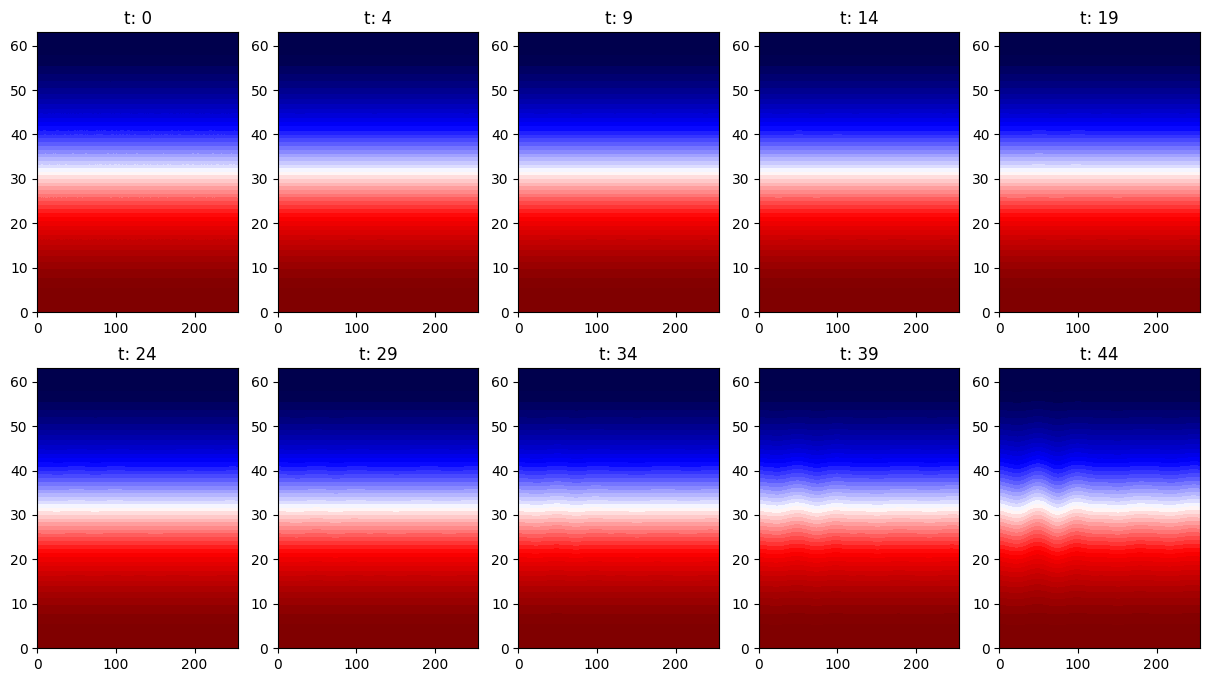

In [5]:
f = h5py.File('/content/snapshots/snapshots_s1.h5', 'r')
T = f['tasks']['buoyancy']
print(np.shape(T)) # dimension = time, x,z
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 8))
for i, t in enumerate(np.linspace(0, T.shape[0]-1, 11).astype(int)):
  print(i, i//5, i%5, t)
  cs=ax[i//5, i%5].contourf(np.transpose(T[t,:,:]),50,cmap='seismic',extend='both')
  ax[i//5, i%5].set_title(f"t: {t}")
  #plt.colorbar(cs)
cs=ax[-1, -1].contourf(np.transpose(T[-1,:,:]),50,cmap='seismic',extend='both')
ax[-1, -1].set_title(f"t: {t}")

(50, 256, 64)
0 0 0 0
1 0 1 5
2 0 2 10
3 0 3 16
4 0 4 21
5 1 0 27
6 1 1 32
7 1 2 38
8 1 3 43
9 1 4 49


Text(0.5, 1.0, 't: 49')

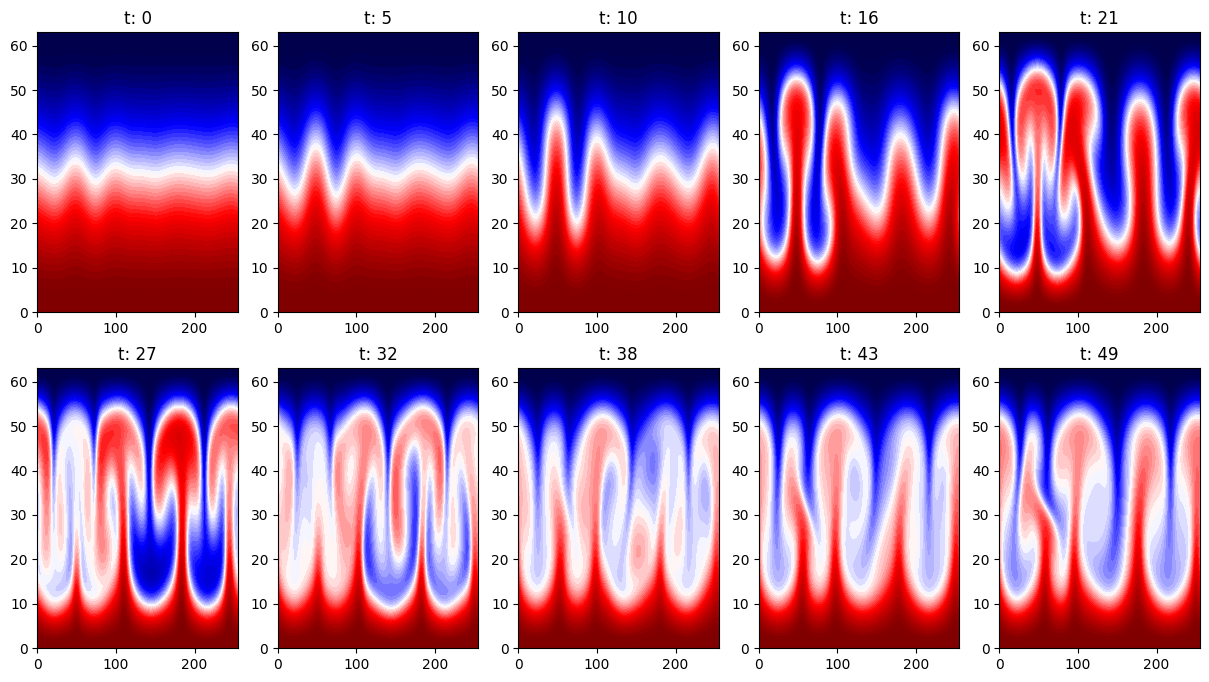

In [6]:
f = h5py.File('/content/snapshots/snapshots_s2.h5', 'r')
T = f['tasks']['buoyancy']
print(np.shape(T)) # dimension = time, x,z
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 8))
for i, t in enumerate(np.linspace(0, T.shape[0]-1, 10).astype(int)):
  print(i, i//5, i%5, t)
  cs=ax[i//5, i%5].contourf(np.transpose(T[t,:,:]),50,cmap='seismic',extend='both')
  ax[i//5, i%5].set_title(f"t: {t}")
  #plt.colorbar(cs)
cs=ax[-1, -1].contourf(np.transpose(T[-2,:,:]),50,cmap='seismic',extend='both')
ax[-1, -1].set_title(f"t: {t}")

(50, 256, 64)
0 0 0 0
1 0 1 5
2 0 2 10
3 0 3 16
4 0 4 21
5 1 0 27
6 1 1 32
7 1 2 38
8 1 3 43
9 1 4 49


Text(0.5, 1.0, 't: 49')

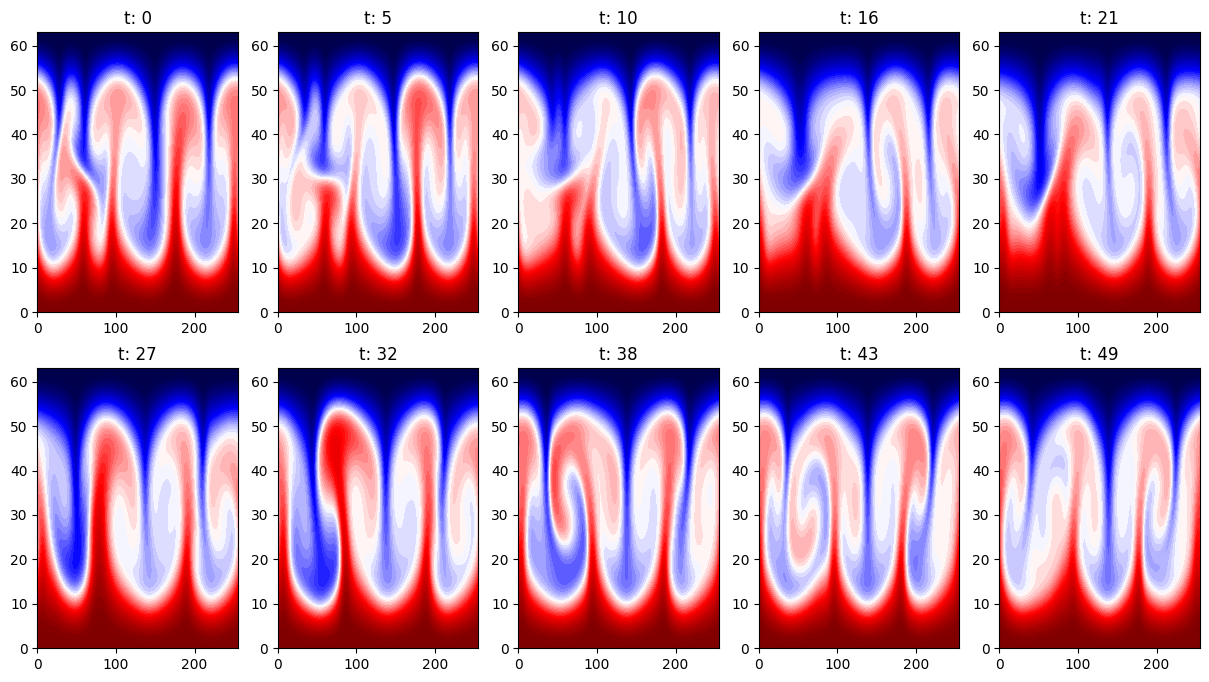

In [7]:
f = h5py.File('/content/snapshots/snapshots_s3.h5', 'r')
T = f['tasks']['buoyancy']
print(np.shape(T)) # dimension = time, x,z
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 8))
for i, t in enumerate(np.linspace(0, T.shape[0]-1, 10).astype(int)):
  print(i, i//5, i%5, t)
  cs=ax[i//5, i%5].contourf(np.transpose(T[t,:,:]),50,cmap='seismic',extend='both')
  ax[i//5, i%5].set_title(f"t: {t}")
  #plt.colorbar(cs)
cs=ax[-1, -1].contourf(np.transpose(T[-2,:,:]),50,cmap='seismic',extend='both')
ax[-1, -1].set_title(f"t: {t}")

(50, 256, 64)
0 0 0 0
1 0 1 5
2 0 2 10
3 0 3 16
4 0 4 21
5 1 0 27
6 1 1 32
7 1 2 38
8 1 3 43
9 1 4 49


Text(0.5, 1.0, 't: 49')

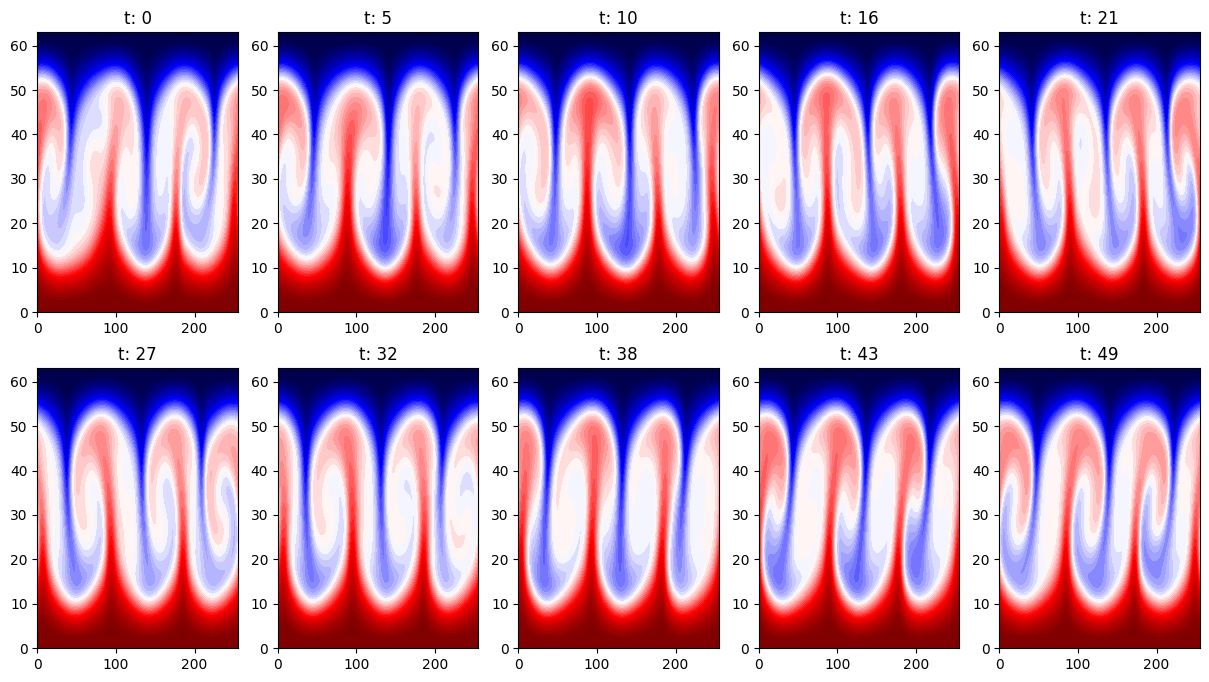

In [8]:
f = h5py.File('/content/snapshots/snapshots_s4.h5', 'r')
T = f['tasks']['buoyancy']
print(np.shape(T)) # dimension = time, x,z
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(15, 8))
for i, t in enumerate(np.linspace(0, T.shape[0]-1, 10).astype(int)):
  print(i, i//5, i%5, t)
  cs=ax[i//5, i%5].contourf(np.transpose(T[t,:,:]),50,cmap='seismic',extend='both')
  ax[i//5, i%5].set_title(f"t: {t}")
  #plt.colorbar(cs)
cs=ax[-1, -1].contourf(np.transpose(T[-2,:,:]),50,cmap='seismic',extend='both')
ax[-1, -1].set_title(f"t: {t}")

In [ ]:
!ls -lt /content/snapshots/

total 51840
-rw-r--r-- 1 root root 13270496 Oct  2 06:54 snapshots_s4.h5
-rw-r--r-- 1 root root 13270496 Oct  2 06:53 snapshots_s3.h5
-rw-r--r-- 1 root root 13270496 Oct  2 06:52 snapshots_s2.h5
-rw-r--r-- 1 root root 13270496 Oct  2 06:51 snapshots_s1.h5


#First Time - Rayleigh number = 2e6
total 51840

-rw-r--r-- 1 root root 13270496 Oct  2 06:18 snapshots_s4.h5

-rw-r--r-- 1 root root 13270496 Oct  2 06:15 snapshots_s3.h5

-rw-r--r-- 1 root root 13270496 Oct  2 06:12 snapshots_s2.h5

-rw-r--r-- 1 root root 13270496 Oct  2 06:09 snapshots_s1.h5

# Second - Rayleigh number = 10
total 51840

-rw-r--r-- 1 root root 13270496 Oct  2 06:45 snapshots_s4.h5

-rw-r--r-- 1 root root 13270496 Oct  2 06:45 snapshots_s3.h5

-rw-r--r-- 1 root root 13270496 Oct  2 06:44 snapshots_s2.h5

-rw-r--r-- 1 root root 13270496 Oct  2 06:44 snapshots_s1.h5
